# LSTM PROJECT TITLE

## PROJECT SUMMARY
Predicting future oil production rates for 5 oil wells

Using the contents of the entire workbook create a 2 paragraph project introduction for ... project. The first paragraph should describe what the project is about and the base LSTM model being used. The second paragraph gives a brief summary of the steps that will be taken to analyze, train, and evaluate the model including EDA, training, testing, hyperparameter tuning, and comparing the base model to the .......... models.

## DATA SOURCE & IMPORT

#### Data Source

- The datasets used in this project are a combination of production data for five crude oil wells and commodity pricing data.
- **Production Data**
  - The historical production data has been provided directly by a small Canadian oil and gas producer.  
  - *Reference*: Private Operator (Anonymous). (2025). Internal oil well production dataset: Five wells in Western Canada.
- **Commodity Pricing Data**
  - Historical crude oil and natural gas commodity pricing data is downloaded from a trusted Canadian petroleum reserve evaluator.
  - *Reference*: McDaniel & Associates Consultants Ltd. (2025, October 1). Price forecasts [Web page]. https://mcdan.com/price-forecasts/

#### Import Python Libraries

In [ ]:
# Import core analysis, visualization, and statistical libraries used throughout the notebook
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from pathlib import Path
import random
import itertools
import json
import requests
import warnings
import logging
from IPython.display import display

import pandas as pd
import numpy as np

from io import StringIO
from textwrap import fill
from fake_useragent import UserAgent

import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional, Conv1D, MaxPooling1D
import tensorflow as tf
from tensorflow import keras
import optuna
from optuna.visualization import plot_parallel_coordinate

# Silence warnings
alt.data_transformers.disable_max_rows()
warnings.filterwarnings('ignore', category=UserWarning)
optuna.logging.set_verbosity(optuna.logging.WARNING)
tf.get_logger().setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

# Set seeds
seed = 666
np.random.seed(seed)
random.seed(seed)

keras.utils.set_random_seed(seed)

# Define model constants
SCALING_FACTOR = 1e-6 # Log transform scaling factor to ensure zero values are handled correctly
SPLIT_RATIO = 0.8     # Train-test or train-validation split ratio
EPOCHS = 100          # Number of epochs to train models over
BATCH_SIZE = 1        # Standard LSTM batch size
PATIENCE = 10         # Early stopping level of patience
N_TRIALS = 30         # Number of hyperparameter tuning trails to conduct

#### Import Production Data
- Production data has been provided directly from the oil company in a `.csv` file.

In [2]:
# Import production dataset file (as provided by the private oil company)
prod_df = pd.read_csv('prod.csv')

# Convert date column to datetime
prod_df['date'] = pd.to_datetime(prod_df['date'])

# Display production dataframe
prod_df

well_name       date  production_hours  oil_producing_daily_avg (bbl/day)  \
0      well_1 2013-01-01               408                       16453.411760   
1      well_1 2013-02-01               629                       16161.119240   
2      well_1 2013-03-01               743                       15883.833110   
3      well_1 2013-04-01               720                       12569.133330   
4      well_1 2013-05-01               696                       10410.724140   
..        ...        ...               ...                                ...   
485    well_5 2018-05-01               744                         253.612903   
486    well_5 2018-06-01               720                         119.500000   
487    well_5 2018-07-01               744                          26.387097   
488    well_5 2018-08-01               120                         100.600000   
489    well_5 2018-09-01               720                          54.500000   

     gas_producing_daily_avg (mcf/day)  water_producing_daily_avg (bbl/day)  
0                          5068.647059                          1439.235294  
1                          5106.848967                           388.769475  
2                          9696.032301                           335.224764  
3                         10888.633330                           119.500000  
4                          7586.517241                           169.172414  
..                                 ...                                  ...  
485                        1446.741935                            48.709677  
486                          35.300000                           104.833333  
487                          45.580645                            24.354839  
488                          70.600000                            25.200000  
489                         188.333333                           264.166667  

[490 rows x 6 columns]

#### Import Commodity Pricing Data
- Commodity price data in `json` format is extracted directly from the McDaniel's website.

In [3]:
# Function to load the commodity price json file and convert it into a dataframe
def import_price_data(url):
    response = requests.get(url, headers={'User-Agent': UserAgent().random})

    data = json.loads(response.content)

    rows = []
    for entry in data:
        date = entry['date']
        row = {'date': date}
        for item in entry['values']:
            base_key = item['key'].replace(' Forecast', '').strip()
            row[f'{base_key}'] = item['usd']
        rows.append(row)
    df = pd.DataFrame(rows)
    df['date'] = pd.to_datetime(df['date'])
    return df

# Define the url links to the pricing data
oil_url = 'https://mcdan.com/forecast/data/oil.json'
gas_url = 'https://mcdan.com/forecast/data/gas.json'

# Create oil and natural gas pricing datasets
oil_prices_df = import_price_data(oil_url)
gas_prices_df = import_price_data(gas_url)

# Define prod_df min/max dates
prod_min_date = prod_df['date'].min()
prod_max_date = prod_df['date'].max()

# Filter oil_prices_df and gas_prices_df by prod_min_date and prod_max_date
oil_prices_df = oil_prices_df[(oil_prices_df['date']>=prod_min_date) & (oil_prices_df['date']<=prod_max_date)]
gas_prices_df = gas_prices_df[(gas_prices_df['date']>=prod_min_date) & (gas_prices_df['date']<=prod_max_date)]

#### Merge Production & Pricing Datasets
- Create the final dataset used for evaluation

In [4]:
# Merge the prod_df, oil_prices_df, and gas_prices_df
df = prod_df.merge(oil_prices_df).merge(gas_prices_df)

# Display combined dataset
df

well_name       date  production_hours  oil_producing_daily_avg (bbl/day)  \
0      well_1 2013-01-01               408                       16453.411760   
1      well_1 2013-02-01               629                       16161.119240   
2      well_1 2013-03-01               743                       15883.833110   
3      well_1 2013-04-01               720                       12569.133330   
4      well_1 2013-05-01               696                       10410.724140   
..        ...        ...               ...                                ...   
485    well_5 2018-05-01               744                         253.612903   
486    well_5 2018-06-01               720                         119.500000   
487    well_5 2018-07-01               744                          26.387097   
488    well_5 2018-08-01               120                         100.600000   
489    well_5 2018-09-01               720                          54.500000   

     gas_producing_daily_avg (mcf/day)  water_producing_daily_avg (bbl/day)  \
0                          5068.647059                          1439.235294   
1                          5106.848967                           388.769475   
2                          9696.032301                           335.224764   
3                         10888.633330                           119.500000   
4                          7586.517241                           169.172414   
..                                 ...                                  ...   
485                        1446.741935                            48.709677   
486                          35.300000                           104.833333   
487                          45.580645                            24.354839   
488                          70.600000                            25.200000   
489                         188.333333                           264.166667   

       WTI   BRENT    EDM    WCS    HH  AECO  STA2  
0    94.83  112.16  88.10  62.09  3.33  3.18  3.08  
1    95.32  116.02  87.12  58.36  3.33  3.03  2.84  
2    92.96  108.56  86.95  66.71  3.81  2.96  2.79  
3    92.07  102.25  89.04  68.79  4.17  3.39  3.18  
4    94.80  102.56  93.55  81.07  4.04  3.63  3.42  
..     ...     ...    ...    ...   ...   ...   ...  
485  69.98   76.98  64.06  53.40  2.83  0.56  0.66  
486  67.87   74.41  61.23  52.79  2.94  0.56  0.57  
487  70.98   74.25  63.18  52.85  2.79  1.18  1.16  
488  68.06   72.53  64.93  48.91  2.91  1.58  1.08  
489  70.23   78.89  61.94  40.84  2.90  1.05  1.04  

[490 rows x 13 columns]

## DATA SUMMARY

#### Dataset Shape & Data Types
- Investigating the number of rows and columns contained in the dataset, and the types of data found in each column.

In [5]:
# Dataset shape
(rows, cols) = df.shape
print(f'The dataset has {rows:,} rows and {cols} columns.\n')

# Dataset data types
df.info()

The dataset has 490 rows and 13 columns.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490 entries, 0 to 489
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   well_name                            490 non-null    object        
 1   date                                 490 non-null    datetime64[ns]
 2   production_hours                     490 non-null    int64         
 3   oil_producing_daily_avg (bbl/day)    490 non-null    float64       
 4   gas_producing_daily_avg (mcf/day)    490 non-null    float64       
 5   water_producing_daily_avg (bbl/day)  490 non-null    float64       
 6   WTI                                  490 non-null    float64       
 7   BRENT                                490 non-null    float64       
 8   EDM                                  490 non-null    float64       
 9   WCS                                  490 non-

#### Feature Descriptions
- The dataset contains a combination of production rates and commodity pricing streams.

Feature | Description | Units | Data Type
---|---|---|---
**well_name** | Name of the producing well | | Categorical
**date** | First day of each month of production | dd/mm/yyy | Datetime
**production_hours** | Number of producing hours a well is on production in a month | hours | Numeric
**oil_producing_daily_avg (bbl/day)** | Monthly average of the daily oil production rate | bbl/d | Numeric
**gas_producing_daily_avg (mcf/day)** | Monthly average of the daily natural gas production rate | mcf/d | Numeric
**water_producing_daily_avg (bbl/day)** | Monthly average of the daily water production rate | bbl/d | Numeric
**WTI** | Monthly average of the West Texas Intermediate crude oil benchmark price | US $/bbl | Numeric
**BRENT** | Monthly average of the Brent crude oil benchmark price | US $/bbl | Numeric
**EDM** | Monthly average of the Edmonton Light Sweet crude oil benchmark price | US $/bbl | Numeric
**WCS** | Monthly average of the Western Canadian Select crude oil benchmark price | US $/bbl | Numeric
**HH** | Monthly average of the Henry Hub natural gas benchmark price | US $/mcf | Numeric
**AECO** | Monthly average of the AECO natural gas benchmark price | US $/mcf | Numeric
**STA2** | Monthly average of the BC Station 2 natural gas benchmark price | US $/mcf | Numeric

> - For this project **the target variable is the `oil_producing_daily_avg (bbl/day)`** column at time $t+1$.

## EDA
The EDA section presents monthly production trends by well, blends in macro indicators, and highlights shut-in periods to reveal The EDA section traces monthly production trends for every well, overlaying macro pricing indicators and shut-in periods to surface operational cycles, sudden changes, and downtime. It also frames the upcoming train/test split within that historical context, so the LSTM preparation later clearly ties back to the exploratory insights.

#### Frequency of Categorical Columns
- Each well has produced for a different length of time, where each row in the dataset represents a month of production.
- It would be interesting to visualize the difference between the first and last day of production by counting the row occurrences in the `well_name` column.

In [6]:
# Visualize months on production
alt.Chart(df).mark_bar().encode(
    alt.X('well_name:N').title(None),
    alt.Y('count():Q').title(None),
    alt.Color('well_name').scale(scheme='viridis')
).properties(
    height = 300,
    width = 500,
    title=alt.Title('Months on Production by Well', fontSize=20, align='right'),
)

alt.Chart(...)

#### Distributions of Numeric Columns
- These are used to visualize how numeric columns are distributed, and to observe any patterns or outliers in the dataset.

In [7]:
# Function to plot a set of histograms for a subset of columns
def plot_numeric_histograms(input_df, subset, chart_title, col_count):
    # Melt the numeric columns into one column
    df_melt = input_df[subset].melt(var_name='feature', value_name='value')

    # Create a base Altair histogram chart
    base_chart = alt.Chart(df_melt).mark_bar(opacity=1, binSpacing=0).encode(
        alt.X('value:Q').axis(title=None).bin(maxbins=50),
        alt.Y('count():Q').axis(title=None).stack(None),
        color = alt.Color('feature:N').scale(scheme='viridis').sort(df.columns).legend(None)
    ).properties(
        width=750 / col_count,
        height=150
    )

    # Display a histogram for each numeric_columns
    chart = alt.ConcatChart(
        title=alt.Title(f'{chart_title}', fontSize=20),
        concat=[base_chart.transform_filter(alt.datum.feature == value).properties(title=value) for value in subset],
        columns=col_count,
    ).configure_title(
        fontSize=10
    ).resolve_axis(
        x='independent',
        y='independent'
    ).resolve_scale(
        x='independent', 
        y='independent'
    )

    return chart

# Define numeric feature columns
numeric_columns = [col for col in df.columns.to_list() if col not in ['well_name','date']]

# Plot numeric histograms
plot_numeric_histograms(df, numeric_columns, 'Numeric Columns Data Distributions', 3)

alt.ConcatChart(...)

> - The `oil_producing_daily_avg (bbl/day)` and `water_producing_daily_avg (bbl/day)` columns seem to be somewhat exponentially distributed, whereas the `gas_producing_daily_avg (mcf/day)` column has more variation and looks to be a skewed distribution.
> - The crude oil commodity prices (`WTI`, `BRENT`, `EDM`, `WCS`) all seem to have bi-modal distributions indicating that those prices may experience periods of high and low price environments.

#### Numeric Columns Pairplot
- This pairplot visualizes the scatterplots and histograms that reveals how production metrics and pricing indicators move together across wells

In [8]:
# # Filter to only numeric features
# numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# pairgrid_df = df[numeric_cols].dropna()

# # Set theme
# sns.set_style('whitegrid')
# sns.set_context('talk', font_scale=0.9)
# sns.set_palette('viridis')
# viridis_colors = sns.color_palette('viridis_r', 5)
# hist_color = viridis_colors[2]
# scatter_color = viridis_colors[-1]
# kde_cmap = sns.color_palette('viridis', as_cmap=True)

# # Build the PairGrid with histograms on the diagonal, scatterplots above, and KDE contours below
# pairgrid = sns.PairGrid(pairgrid_df, diag_sharey=False)
# pairgrid.map_diag(sns.histplot, color=hist_color, edgecolor='white', linewidth=1.0)
# pairgrid.map_upper(sns.scatterplot, color=scatter_color, s=25, alpha=0.7, edgecolor='white', linewidth=0.3)
# pairgrid.map_lower(sns.kdeplot, fill=True, thresh=0.04, levels=5, cmap=kde_cmap, linewidths=0.8)

# # Rotate and wrap long axis labels
# for ax in pairgrid.axes.flatten():
#     ax.tick_params(axis='x', labelrotation=90)
#     ax.tick_params(axis='y', labelrotation=0)
#     ax.set_xlabel(fill(ax.get_xlabel(), 12))
#     ax.set_ylabel(fill(ax.get_ylabel(), 12))

# # Remove extra whitespace and add an overall title
# plt.subplots_adjust(wspace=0.05, hspace=0.05)
# pairgrid.fig.suptitle('Numeric Feature Relationships', y=1.02)

# pairgrid

> - Obvious correlations are observed between the production volumes and production rates. This makes sense since they are just a transformation of each other (as described in the Feature Descriptions section).
> - Correlations also exist among the crude oil pricing columns (`WTI`, `BRENT`, `EDM`, `WCS`). These are not unusual since most crude oils are priced relative to WTI. Similarly correlations are also observed for the natural gas prices between `AECO` and `STA2`. This is expected since both commodites are traded into similar markets.
> - No other obvious correlations are observed among the other numeric columns.

#### Correlation Matrix
- The correlation matrix is a heatmap of pairwise correlations between production and pricing features, helping this analysis quickly spot which variables move together before selecting inputs for the LSTM

<Axes: title={'center': 'Numeric Feature Correlation Matrix'}>

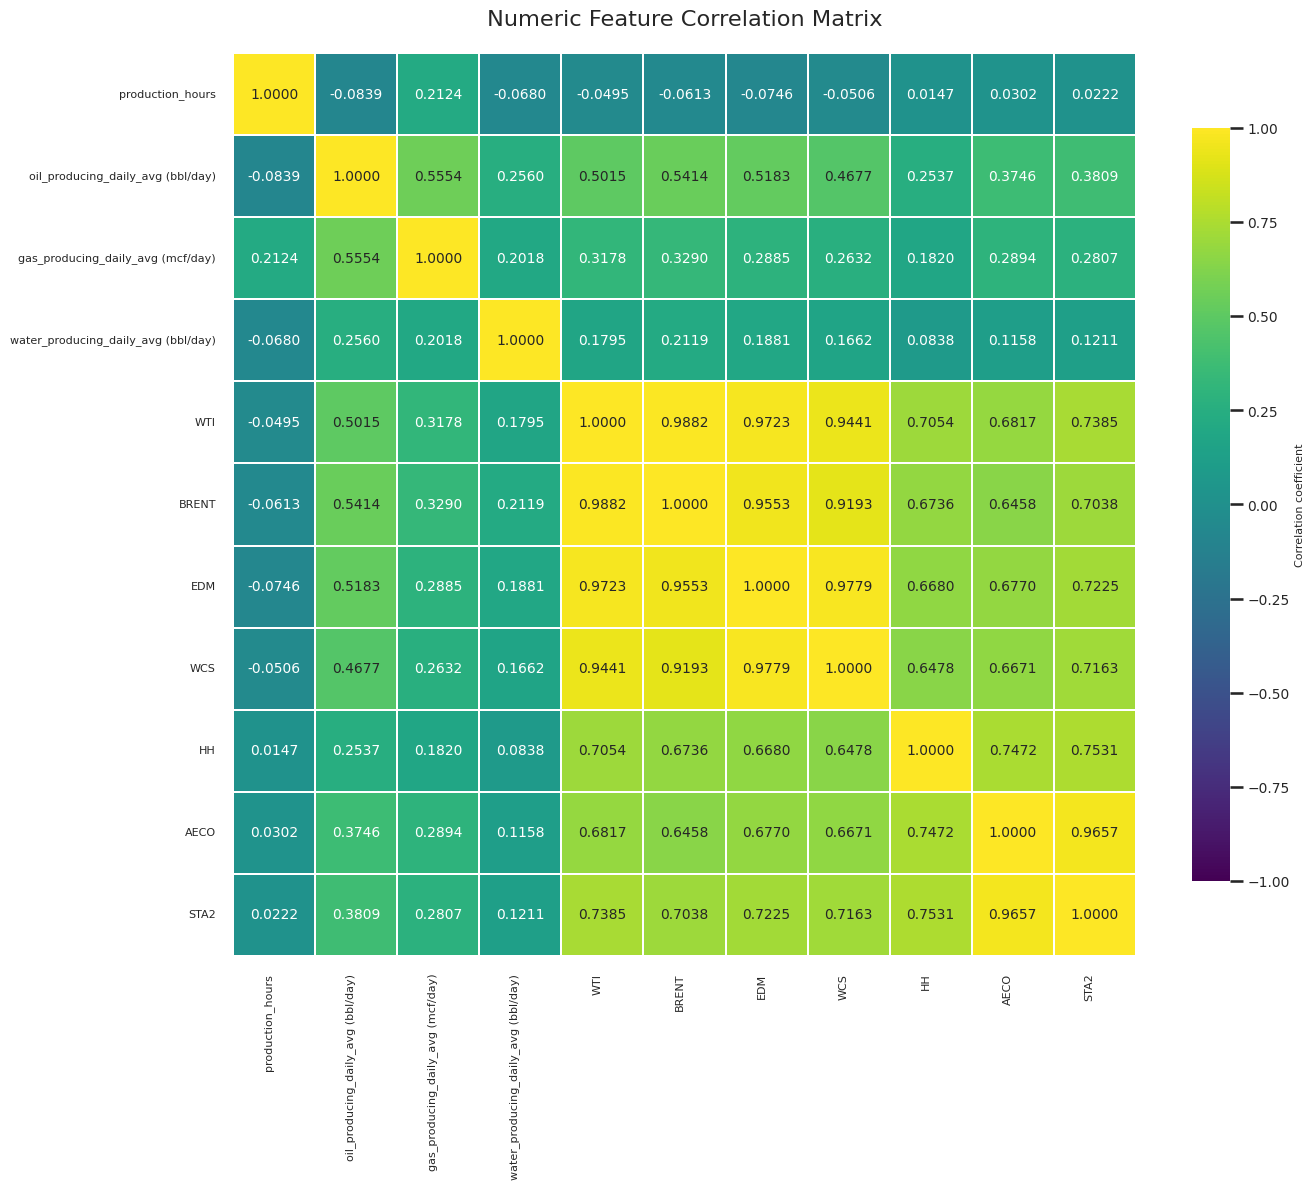

In [9]:
# Compute the correlation matrix across all numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
corr_matrix = df[numeric_cols].corr()

# Plot heatmap
sns.set_style('whitegrid')
sns.set_context('talk', font_scale=0.9)
plt.figure(figsize=(14, 12))
heatmap = sns.heatmap(
    corr_matrix,
    cmap='viridis',
    vmin=-1,
    vmax=1,
    annot=True,
    fmt='.4f',
    annot_kws={'size': 10},
    linewidths=0.3,
    cbar_kws={'label': 'Correlation coefficient', 'shrink': 0.8},
    square=True
)

# Resize the legend
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=10)
cbar.set_label('Correlation coefficient', size=8)

# Realign axis labels
heatmap.set_title('Numeric Feature Correlation Matrix', pad=20)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=90, ha='right', fontsize=8)
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0, fontsize=8)
plt.tight_layout()

heatmap

> Correlations that were visually observed in the pairplot are confirmed in the correlation heatmap.

#### Production Time Series Plots
- Oil and natural gas production rates typically exponentially decline over time so they are plotted on a semi-log plot over time.

In [10]:
# Create labels for plot
prod_rate_dict = {
    'production_hours':'Hours On Production (hrs)',
    'oil_producing_daily_avg (bbl/day)':'Oil Production (bbl/d)',
    'gas_producing_daily_avg (mcf/day)':'Gas Production (mcf/d)',
    'water_producing_daily_avg (bbl/day)':'Water Production (bbl/d)'
}

# Convert data into a dataframe for Altair plotting
prod_rate_chart_df = (
    df[['well_name', 'date'] + [k for k in prod_rate_dict.keys()]]
        .rename(prod_rate_dict, axis=1)
        .replace({0:np.nan})
        .melt(id_vars=['well_name', 'date'], value_vars=[v for v in prod_rate_dict.values()])
)

# Create plot of log-scaled time series for oil rate, gas rate, water rate, and hours on for each well
alt.Chart(prod_rate_chart_df).mark_line().encode(
    alt.X('date:T').title(None),
    alt.Y('value:Q').scale(type='log').title('Production Rate (bb/d or mcf/d)'),
    alt.Color('variable:N').scale(domain=[v for v in prod_rate_dict.values()], range=['grey', '#2ca02c', '#d62728', 'steelblue']),
    alt.Row('well_name:N').title(None),
    alt.Tooltip(['value:Q'])
).properties(
    height = 200,
    width = 800,
    title=alt.Title('Oil, Gas, and Water Production Rates Over Time', fontSize=20, anchor='start')
)

alt.Chart(...)

> Comments about production plots...

#### Oil Production Rate Moving Averages
- Visualizing the 12 month, 24, and 36 months oil production rate moving averages.

In [11]:
# Create dataset for moving-average smoothing
ma_chart_df = df[['well_name', 'date', 'oil_producing_daily_avg (bbl/day)']].replace({0:np.nan})

# Define the moving-average windows
window_specs = [
    (12, '12-month MA'),
    (24, '24-month MA'),
    (36, '36-month MA'),
]

# Define moving-average line colors
window_colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
color_scale = alt.Scale(
    domain=[label for _, label in window_specs],
    range=window_colors
)

# Build base MA chart
base = alt.Chart(ma_chart_df).encode(
    alt.X('date:T').title('Date')
)

# Plot oil production line chart
raw_line = base.mark_line(color='green', opacity=0.2, size=5).encode(
    alt.Y('oil_producing_daily_avg (bbl/day):Q').title('Oil producing daily avg (bbl/day)').scale(type='log')
)

# Create each moving-average line charts
ma_layers = []
for window, label in window_specs:
    ma_layer = base.transform_window(
        rolling_mean='mean(oil_producing_daily_avg (bbl/day))',
        frame=[-(window - 1), 0],
        groupby=['well_name'],
        sort=[alt.SortField('date')]
    ).transform_calculate(
        window_label=f"'{label}'"
    ).mark_line(size=3, opacity=0.75, strokeDash=[10,4]).encode(
        y='rolling_mean:Q',
        color=alt.Color('window_label:N').scale(color_scale).title('Moving Average')
    ).properties(
        height = 200,
        width = 800,
    )
    ma_layers.append(ma_layer)

# Layer the raw_line and ma_layer charts, facet by well
layered_ma_chart = alt.layer(*ma_layers, raw_line).facet(
    row=alt.Row('well_name:N', title='Well')
).properties(
    title=alt.Title('12, 24, and 36 Month Moving Averages of the Oil Production Rate (bbl/d)', fontSize=20, anchor='start')
)

layered_ma_chart

alt.FacetChart(...)

> The 12, 24, and 36-month moving average curves show that every well’s oil production rate follows a steady downward slope, with the longer windows smoothing out the month-to-month volatility. Large negative spikes mark occasional shut-ins or outages, but the multi-year trend remains a gradual decline across all wells.

#### Oil Production Percent Change
- The month-to-month percent change chart tracks how each well’s production jumps or drops from one month to the next, helping the analysis identify volatility bursts or shut-in events to account for when modeling the LSTM

In [12]:
# Compute month-over-month percent change in oil production for each well
pct_change_df = df[['well_name', 'date', 'oil_producing_daily_avg (bbl/day)']].copy()
pct_change_df = pct_change_df.sort_values(['well_name', 'date'])
pct_change_df['pct_change'] = pct_change_df.groupby('well_name')['oil_producing_daily_avg (bbl/day)'].pct_change() * 100
pct_change_df = pct_change_df.dropna(subset=['pct_change'])
pct_change_df['pct_change'] = pct_change_df['pct_change'].clip(-100, 100)

# Define positive/negative color scale
color_scale = alt.Scale(domain=['Increase', 'Decrease'], range=['#2ca02c', '#d62728'])

# Plot a the percent change chart
pct_change_chart = alt.Chart(pct_change_df).mark_bar().encode(
    x=alt.X('date:T', title='Date'),
    y=alt.Y('pct_change:Q', title='Month-to-month % change', scale=alt.Scale(domain=[-100, 100])),
    color=alt.Color(
        'change_direction:N',
        scale=color_scale,
        legend=alt.Legend(title='Direction')
    ),
    tooltip=[
        alt.Tooltip('well_name:N', title='Well'),
        alt.Tooltip('date:T', title='Date'),
        alt.Tooltip('pct_change:Q', title='% change', format='.2f')
    ]
).transform_calculate(
    change_direction="datum.pct_change >= 0 ? 'Increase' : 'Decrease'"
).properties(
    height=200,
    width=800
).facet(
    row=alt.Row('well_name:N', title='Well')
).resolve_scale(
    y='shared'
).properties(
    title=alt.Title('Month-to-Month Percent Change of the Oil Production Rate', fontSize=20, anchor='start', subtitle='(capped at +/-100%)')
)

pct_change_chart

alt.FacetChart(...)

> edit this....
> - More negative rather than positive percent changes are prevalent for each well. This makes sense because the production rate typically consistently declines over time.
> - It would be interesting to study the green bars to understand what occurred to cause an increase in oil production (which is a good thing).

#### Seasonal Decomposition Plots
- Seasonal decomposition charts break each time series into trend, seasonal, and residual components, revealing long-term decline, recurring seasonal patterns, and irregular shocks separately.
- In this analysis they help determine whether seasonal patterns or residual noise should be modeled explicitly or if the LSTM can focus mostly on the trend and notable anomalies.

In [13]:
# Collect seasonal decomposition components for every well
decomposition_records = []
value_col = 'oil_producing_daily_avg (bbl/day)'

for well_name, group in df[['well_name', 'date', value_col]].dropna(subset=[value_col]).sort_values('date').groupby('well_name'):
    well_series = group.set_index('date')[value_col]
    monthly_series = well_series.resample('MS').mean().interpolate(limit_direction='both')

    if len(monthly_series.dropna()) < 24:
        continue

    decomposition = seasonal_decompose(
        monthly_series,
        model='additive',
        period=12,
        extrapolate_trend='freq'
    )

    component_map = {
        'Observed': decomposition.observed,
        'Trend': decomposition.trend,
        'Seasonal': decomposition.seasonal,
        'Residual': decomposition.resid
    }

    for component_name, component_values in component_map.items():
        component_df = component_values.reset_index()
        component_df.columns = ['date', 'value']
        component_df['component'] = component_name
        component_df['well_name'] = well_name
        decomposition_records.append(component_df)

# Combine component data and drop rows created by leading/trailing NaNs
seasonal_decomposition_df = pd.concat(decomposition_records, ignore_index=True)
seasonal_decomposition_df = seasonal_decomposition_df.dropna(subset=['value'])
component_order = ['Observed', 'Trend', 'Seasonal', 'Residual']

# Plot the observed, trend, seasonal, and residual series for each well in a faceted grid
seasonal_decomposition_chart = alt.Chart(seasonal_decomposition_df).mark_line(color='#2ca02c').encode(
    x=alt.X('date:T').title(None),
    y=alt.Y('value:Q').title(None),
    row=alt.Row('component:N', sort=component_order, title=None),
    column=alt.Column('well_name:N', title='Well'),
    color=alt.Color('well_name:N', title='Well', scale=alt.Scale(scheme='viridis'))
).resolve_scale(
    y='independent'
).properties(
    height=100,
    width=200,
    title=alt.Title('Seasonal Decomposition of the Oil Production Rate', fontSize=20, anchor='start')
)

seasonal_decomposition_chart

alt.Chart(...)

> The seasonal decomposition charts show a steep decline in each well’s long-term trend followed by a flat tail, while the seasonal component oscillates annually with consistent amplitude—**clear evidence of recurring 12-month seasonality**. Residuals remain relatively small after the initial drop, suggesting most structure is captured by the trend and seasonal terms. LSTM's inherently handle seasonality, but if model fits are insufficient then we could consider applying temporal differencing to account for these cyclical effects.

#### Autocorrelation Plot
- The autocorrelation plot shows how each well’s production correlates with its past values at different lags, helping this analysis gauge how far back the LSTM needs to look to capture meaningful temporal dependencies.

In [14]:
# Group by well
well_groups = (
    df[['well_name', 'date', 'oil_producing_daily_avg (bbl/day)']]
    .dropna(subset=['oil_producing_daily_avg (bbl/day)'])
    .sort_values('date')
    .groupby('well_name')
)

# Define horizon to analyze autocorrelation over
horizon = 36

# Create ACF datasets
acf_records = []
for well_name, group in well_groups:
    monthly_series = group.set_index('date')[value_col].resample('MS').mean().interpolate(limit_direction='both')
    acf_values = acf(monthly_series, nlags=horizon, fft=False, missing='drop')
    for lag in range(1, horizon + 1):
        acf_records.append({
            'well_name':     well_name,
            'lag':           lag,
            'acf':           acf_values[lag],
            'horizon_label': f"{horizon}-month"
        })

# Plot ACF chart
acf_df = pd.DataFrame(acf_records)
acf_chart = alt.Chart(acf_df).mark_bar().encode(
    x=alt.X('lag:O', title='Lag (months)', axis=alt.Axis(values=[6, 12, 18, 24, 30, 36])),
    y=alt.Y('acf:Q', title='Autocorrelation', scale=alt.Scale(domain=[-1, 1])),
    column=alt.Column('well_name:N', title=None),
    row=alt.Row('horizon_label:N', sort=[f"36-month"], title='Horizon'),
    color=alt.condition(alt.datum.acf >= 0, alt.value('#1f77b4'), alt.value('#d62728'))
).resolve_scale(
    y='shared'
).properties(
    height=200,
    width=200,
    title=alt.Title('36 month Autocorrelation of the Oil Production Rate', fontSize=20, anchor='start')
)

acf_chart

alt.Chart(...)

> Autocorrelation stays strongly positive through roughly the first 12–18 months for every well, confirming that recent production levels heavily influence the next year’s output. Beyond about 24 months the correlations decay to near zero or slightly negative, suggesting the model can safely prioritize shorter lookback windows without losing much signal. With this knowledge **I'll consider testing look back windows of 12, 24, and 36 months for the LSTM models**.

## DATA CLEANING & PREPROCESSING

#### Adding Columns Required for Modeling
- A `months_on` column is added that calculates the number of months the well has been on production since its first month of production.
- A set of dummy variable columns are created that define general states of the oil and gas industry over time.

In [15]:
# Add a months_on column which is the number of months a well has produced since it was first put on production
df['months_on'] = df.groupby('well_name')['date'].transform(lambda s: s.rank(method='first').astype(int))

In [16]:
# Add columns that identify key events affecting the oil and gas industry
indicator_windows = {
    'middle_instability_tightening_supply': [('2009-01-01', '2014-08-01')],
    'opec_oversupply_during_downturn':      [('2014-09-01', '2016-02-01')],
    'opec_undersupply_during_recovery':     [('2016-03-01', '2020-02-01')],
    'covid':                                [('2020-03-01', '2022-06-01')],
    'ukraine_war':                          [('2022-02-01', '2025-11-01')]
}

# Create date index
min_prod_date = df['date'].min().to_period('M').to_timestamp()
date_index = pd.date_range(start=min_prod_date, end='2025-11-01', freq='MS')

# Create & populate dummy variables
dummy_df = pd.DataFrame({'date': date_index})
for indicator, windows in indicator_windows.items():
    dummy_df[indicator] = 0
    for start, end in windows:
        start_ts = pd.Timestamp(start)
        end_ts = pd.Timestamp(end)
        mask = (dummy_df['date'] >= start_ts) & (dummy_df['date'] <= end_ts)
        dummy_df.loc[mask, indicator] = 1

# Merge dummy_df with the dataset
df = df.merge(dummy_df, how='left')

# Display the updated dataset
df

well_name       date  production_hours  oil_producing_daily_avg (bbl/day)  \
0      well_1 2013-01-01               408                       16453.411760   
1      well_1 2013-02-01               629                       16161.119240   
2      well_1 2013-03-01               743                       15883.833110   
3      well_1 2013-04-01               720                       12569.133330   
4      well_1 2013-05-01               696                       10410.724140   
..        ...        ...               ...                                ...   
485    well_5 2018-05-01               744                         253.612903   
486    well_5 2018-06-01               720                         119.500000   
487    well_5 2018-07-01               744                          26.387097   
488    well_5 2018-08-01               120                         100.600000   
489    well_5 2018-09-01               720                          54.500000   

     gas_producing_daily_avg (mcf/day)  water_producing_daily_avg (bbl/day)  \
0                          5068.647059                          1439.235294   
1                          5106.848967                           388.769475   
2                          9696.032301                           335.224764   
3                         10888.633330                           119.500000   
4                          7586.517241                           169.172414   
..                                 ...                                  ...   
485                        1446.741935                            48.709677   
486                          35.300000                           104.833333   
487                          45.580645                            24.354839   
488                          70.600000                            25.200000   
489                         188.333333                           264.166667   

       WTI   BRENT    EDM    WCS    HH  AECO  STA2  months_on  \
0    94.83  112.16  88.10  62.09  3.33  3.18  3.08          1   
1    95.32  116.02  87.12  58.36  3.33  3.03  2.84          2   
2    92.96  108.56  86.95  66.71  3.81  2.96  2.79          3   
3    92.07  102.25  89.04  68.79  4.17  3.39  3.18          4   
4    94.80  102.56  93.55  81.07  4.04  3.63  3.42          5   
..     ...     ...    ...    ...   ...   ...   ...        ...   
485  69.98   76.98  64.06  53.40  2.83  0.56  0.66         65   
486  67.87   74.41  61.23  52.79  2.94  0.56  0.57         66   
487  70.98   74.25  63.18  52.85  2.79  1.18  1.16         67   
488  68.06   72.53  64.93  48.91  2.91  1.58  1.08         68   
489  70.23   78.89  61.94  40.84  2.90  1.05  1.04         69   

     middle_instability_tightening_supply  opec_oversupply_during_downturn  \
0                                       1                                0   
1                                       1                                0   
2                                       1                                0   
3                                       1                                0   
4                                       1                                0   
..                                    ...                              ...   
485                                     0                                0   
486                                     0                                0   
487                                     0                                0   
488                                     0                                0   
489                                     0                                0   

     opec_undersupply_during_recovery  covid  ukraine_war  
0                                   0      0            0  
1                                   0      0            0  
2                                   0      0            0  
3                                   0      0            0  
4                                   0      0            0  
..  

#### Scale Data
- Models are trained using the concatenation of all the well's `X_train` and `y_train` datasets, and then individually predicted and tested using each wells `X_test` and `y_test` datasets.
- Because of this I scale the entire dataset's numeric features to a mean of 0 and standard deviation of 1 to improve generality of the LSTM models.
- Numeric features that are scaled are:
  - `production_hours`
  - `oil_producing_daily_avg (bbl/day)`
  - `gas_producing_daily_avg (mcf/day)`
  - `water_producing_daily_avg (bbl/day)`
  - `WTI`
  - `BRENT`
  - `EDM`
  - `WCS`
  - `HH`
  - `AECO`
  - `STA2`
  - `months_on`

In [17]:
# Fit the StandardScaler so X features can be scaled later
scaler = StandardScaler()
scaler.fit(df.iloc[:, 2:14])

StandardScaler()

#### Train-Test Split
- LSTM models expect a 3-dimensional dataframe as input with a shape of: ($\textit{samples}$, $\textit{look back}$, $\textit{number of features}$).
  - Where:
    - $\textit{samples}$ = are the number of unique time slices generated from the set of features $X$
    - $\textit{look back}$ = is the length of each sample (measured in months)
    - $\textit{number of features}$ = are the number of feature variables in the input matrix $X$
- The `create_dataset` function below creates the 3-dimensional LSTM inputs for a given input dataset
  - The target values $y$ are the `oil_producing_daily_avg (bbl/day)` values taken at time $t+1$
  - The feature matrix $X$ contains 17 features:
    - `production_hours`
    - `oil_producing_daily_avg (bbl/day)`
    - `gas_producing_daily_avg (mcf/day)`
    - `water_producing_daily_avg (bbl/day)`
    - `WTI`
    - `BRENT`
    - `EDM`
    - `WCS`
    - `HH`
    - `AECO`
    - `STA2`
    - `months_on`
    - `middle_instability_tightening_supply`
    - `opec_oversupply_during_downturn`
    - `opec_undersupply_during_recovery`
    - `covid`
    - `ukraine_war`
- $X$ and $y$ are split into training and testing sets, where:
  - the first 80% of the time series is used as the training set, and 
  - the last 20% of the time series is used as the testing set
- Scaling is applied where:
  - The $X$ numeric values are scaled using the standard scaler mentioned above
  - $y$ is log transformed (with a scaling factor of 1e-6 added to avoid errors when $y=0$)
- The `X_train` and `y_train` sets for each well are stacked into one so the model can be trained on one complete training dataset

In [18]:
# Function to scale and split a dataset into X_train, X_test, y_train, y_test
def create_train_test_split(dataset, look_back, scaler):
    # Drop date and well_name columns
    dataset = dataset[[col for col in dataset.columns if col not in ['date', 'well_name']]]

    # Split into X & y
    X = dataset.iloc[0:(len(dataset)-1), :].to_numpy()
    y = dataset.iloc[1:, 1]

    # Scale the numeric features in X
    X[:,:12] = scaler.transform(X[:,:12])

    # Log transform y
    y_log = np.log(y + SCALING_FACTOR).to_numpy()

    # Split into train & test sets
    train_idx = int(len(X) * SPLIT_RATIO)
    X_train, X_test, y_train, y_test = [], [], [], []

    # Create X_train & y_train datasets
    for i in range(train_idx - look_back + 1):
        X_train_sample = X[i:(i + look_back), :]
        X_train.append(X_train_sample)
        y_train.append(y_log[i + look_back - 1])
    X_train = np.array(X_train) # X_train.shape = (train_idx - look_back + 1, look_back, n_features)
    y_train = np.array(y_train) # y_train.shape = (train_idx - look_back + 1, )

    # Create X_test & y_test datasets
    for i in range(train_idx - look_back + 1, len(X) - look_back + 1):
        X_test_sample = X[i:(i+look_back), :]
        X_test.append(X_test_sample)
        y_test.append(y_log[i + look_back - 1])
    X_test = np.array(X_test) # X_test.shape = (len(X) - train_idx, look_back, n_features)
    y_test = np.array(y_test) # y_test.shape = (len(y) - train_idx, )

    return X_train, X_test, y_train, y_test

# Function to loop over look_back windows and well_names to create a dictionary of train-test datasets that will be used for model training
def create_train_test_dict(df, scaler):
    train_test_dict = {}
    for look_back in [12, 24, 36]:
        for well_name in df['well_name'].unique():

            # Ensure nested levels exist
            if well_name not in train_test_dict:
                train_test_dict[well_name] = {}
            if look_back not in train_test_dict[well_name]:
                train_test_dict[well_name][look_back] = {}

            # Extract dataset
            dataset = df[df['well_name'] == well_name]
            X_train, X_test, y_train, y_test = create_train_test_split(dataset, look_back, scaler)

            # Create entires
            train_test_dict[well_name][look_back] = {
                'X_train': X_train,
                'X_test':  X_test,
                'y_train': y_train,
                'y_test':  y_test
            }
            
    return train_test_dict

# Generate datasets dictionary
train_test_dict = create_train_test_dict(df, scaler)

In [19]:
# Dataset shapes from train_test_dict for X_train and y_train for lookbacks = 12, 24, and 36 months
print('X_train has shape (samples, look_back, n_features)\ny_train has shape (samples, )')
for look_back in [12, 24, 36]:
    _x_train = np.concatenate([train_test_dict[well_name][look_back]['X_train'] for well_name in df['well_name'].unique()], axis=0)
    _y_train = np.concatenate([train_test_dict[well_name][look_back]['y_train'] for well_name in df['well_name'].unique()], axis=0)
    print(f'\nCombined training dataset shapes for look_back = {look_back}:\n-> X_train : {_x_train.shape}\n-> y_train : {_y_train.shape}')

X_train has shape (samples, look_back, n_features)
y_train has shape (samples, )

Combined training dataset shapes for look_back = 12:
-> X_train : (332, 12, 17)
-> y_train : (332,)

Combined training dataset shapes for look_back = 24:
-> X_train : (272, 24, 17)
-> y_train : (272,)

Combined training dataset shapes for look_back = 36:
-> X_train : (212, 36, 17)
-> y_train : (212,)


## LSTM MODELING
Describe base vanilla LSTM model...

#### Define LSTM Models
- In this analysis I'll be evaluating 4 types of LSTM model. The first is a Vanilla LSTM, which I call my Base LSTM
- The base model is used as a datum to compare to the other models to
- The other models are the Bidirectional LSTM, Stacked LSTM, and CNN-LSTM.

In [20]:
# Define LSTM model instances
def create_LSTM_model(model_type, n_nodes, look_back, learning_rate, dropout, n_features):
    strategy = tf.distribute.MirroredStrategy() # Utilize GPUs
    with strategy.scope():
        model = Sequential()
        if model_type == 'base': # Base LSTM
            model.add(LSTM(n_nodes, input_shape=(look_back, n_features)))
        if model_type == 'bidirectional': # Bidirectional LSTM
            model.add(Bidirectional(LSTM(n_nodes), input_shape=(look_back, n_features)))
        if model_type == 'stacked': # Stacked LSTM
            model.add(LSTM(n_nodes * 2, return_sequences=True, input_shape=(look_back, n_features)))
            model.add(LSTM(n_nodes))
        if model_type == 'cnn': # CNN-LSTM
            model.add(Conv1D(filters=32, kernel_size=3, padding='causal', input_shape=(look_back, n_features)))
            model.add(MaxPooling1D(pool_size=2))
            model.add(LSTM(n_nodes))
        model.add(Dropout(dropout))
        model.add(Dense(1))
        model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=learning_rate))
    return model

#### Fit Base LSTM Model
- Fit an LSTM model using given X_train and y_train
- Function generates:
  - Train & test RMSE scores
  - Train-validation loss plot (with 20% of the data used for validation)
  - Train and test actual vs pred line plots

I0000 00:00:1764455103.159724 1810451 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1756 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 4)              │           352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 357 (1.39 KB)

 Trainable params: 357 (1.39 KB)

 Non-trainable params: 0 (0.00 B)

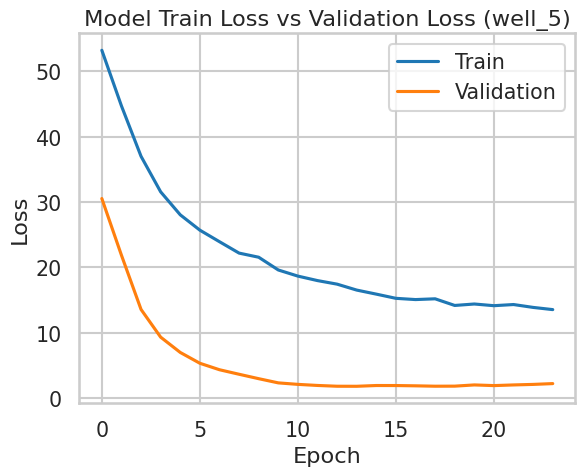

In [21]:
# Fit base LSTM
def fit_lstm(model):
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE) # Add early stopping to prevent overfitting
    history = model.fit(
        X_train,
        y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=(1-SPLIT_RATIO),
        shuffle=False,
        verbose=0,
        callbacks=[early_stopping]
    )
    return history

# Create loss plot
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'Model Train Loss vs Validation Loss ({well_name})')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')

# Define base LSTM model inputs
model_type = 'base'
look_back = 12
n_nodes = 4
learning_rate = 0.001
dropout = 0.1

# Generate X_train and y_train datasets for the given n_nodes, look_back and learning_rate
X_train = np.concatenate([train_test_dict[well_name][look_back]['X_train'] for well_name in train_test_dict.keys()], axis=0)
y_train = np.concatenate([train_test_dict[well_name][look_back]['y_train'] for well_name in train_test_dict.keys()], axis=0)

# Generate the base model instance and display model summary
model = create_LSTM_model(model_type, n_nodes, look_back, learning_rate, dropout, X_train.shape[2])
model.summary()

# Fit the base model LSTM and display the loss plot
history = fit_lstm(model)
plot_loss(history)

> Comments on loss plot ...

#### Well 1 Base LSTM Prediction


Root Mean Squared Error Scores (well_1)

Train RMSE: 693.3
Test RMSE: 534.2


Actual vs Predicted Plots (well_1)



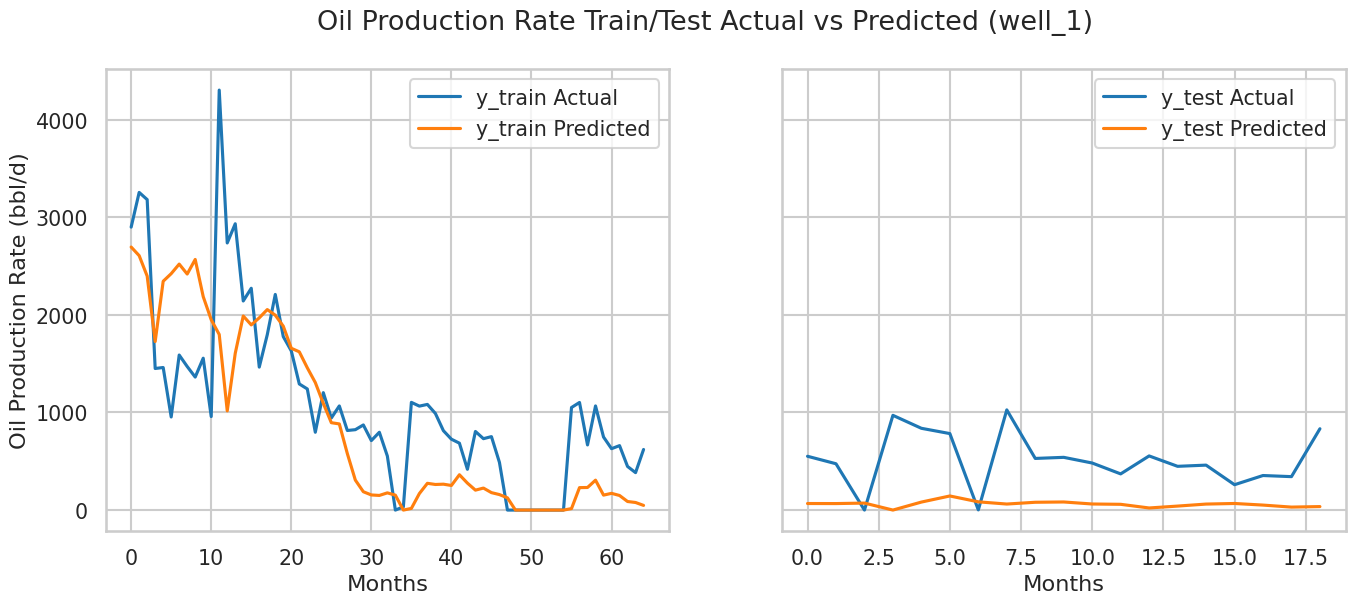

In [22]:
# Function to predict oil production from train-test datasets
def predict_oil_production(train_test_dict, well_name, look_back, history):
    X_train = train_test_dict[well_name][look_back]['X_train']
    y_train = train_test_dict[well_name][look_back]['y_train']
    X_test = train_test_dict[well_name][look_back]['X_test']
    y_test = train_test_dict[well_name][look_back]['y_test']

    # Make train-test predictions
    trainPredict = history.model.predict(X_train, verbose=0)
    testPredict = history.model.predict(X_test, verbose=0)

    # Unscale target variables and predictions
    y_train = np.exp(y_train) - SCALING_FACTOR
    trainPredict = np.exp(trainPredict) - SCALING_FACTOR
    y_test = np.exp(y_test) - SCALING_FACTOR
    testPredict = np.exp(testPredict) - SCALING_FACTOR

    # Calculate train-test RMSE
    print('\n============================================================================')
    print(f'Root Mean Squared Error Scores ({well_name})')
    print('============================================================================\n')   
    train_rmse = np.sqrt(mean_squared_error(y_train, trainPredict))
    test_rmse = np.sqrt(mean_squared_error(y_test, testPredict))
    print(f'Train RMSE: {train_rmse:,.1f}')
    print(f'Test RMSE: {test_rmse:,.1f}\n')

    # Actual vs predicted train-test line charts
    print('\n============================================================================')
    print(f'Actual vs Predicted Plots ({well_name})')
    print('============================================================================\n')   
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 6), sharey=True)
    ax1.plot(y_train, label='y_train Actual')
    ax1.plot(trainPredict, label='y_train Predicted')
    ax1.legend()
    ax1.set_ylabel('Oil Production Rate (bbl/d)')
    ax1.set_xlabel('Months')
    ax2.plot(y_test, label='y_test Actual')
    ax2.plot(testPredict, label='y_test Predicted')
    ax2.legend()
    ax2.set_xlabel('Months')
    fig.suptitle(f'Oil Production Rate Train/Test Actual vs Predicted ({well_name})')

# Fit LSTM model and predict for well_1
predict_oil_production(train_test_dict, 'well_1', look_back, history)

#### Well 2 Base LSTM Prediction


Root Mean Squared Error Scores (well_2)

Train RMSE: 856.2
Test RMSE: 157.3


Actual vs Predicted Plots (well_2)



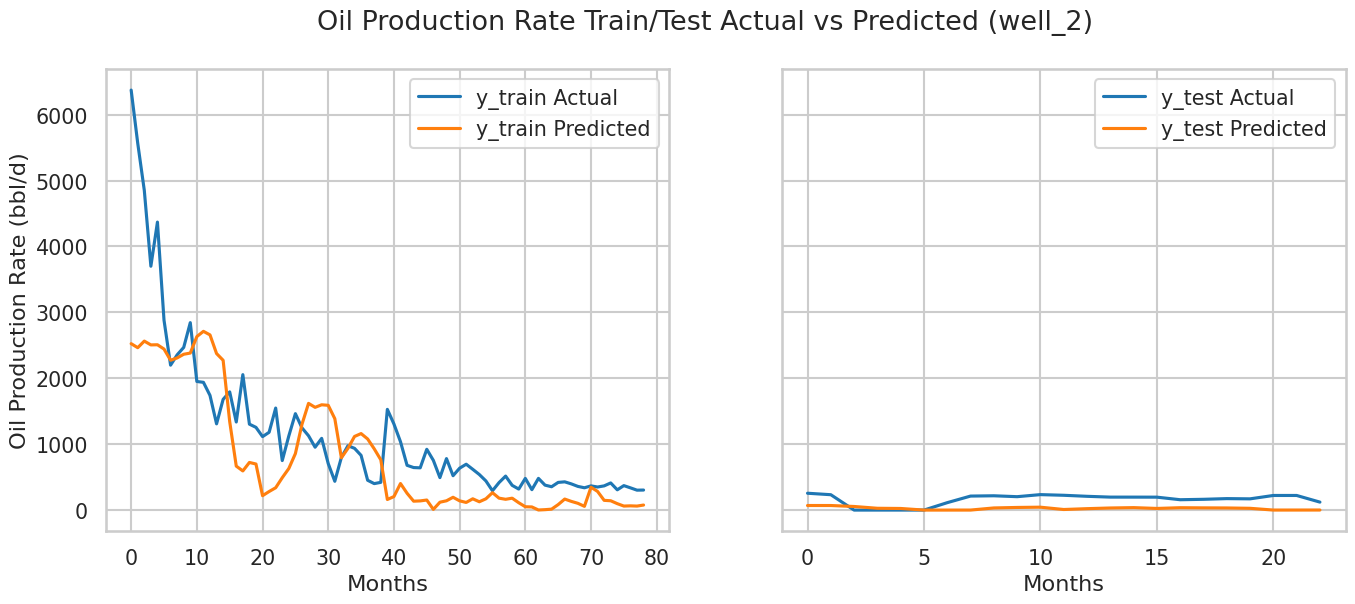

In [23]:
# Fit LSTM model and predict for well_2
predict_oil_production(train_test_dict, 'well_2', look_back, history)

#### Well 3 Base LSTM Prediction


Root Mean Squared Error Scores (well_3)

Train RMSE: 1,315.3
Test RMSE: 309.6


Actual vs Predicted Plots (well_3)



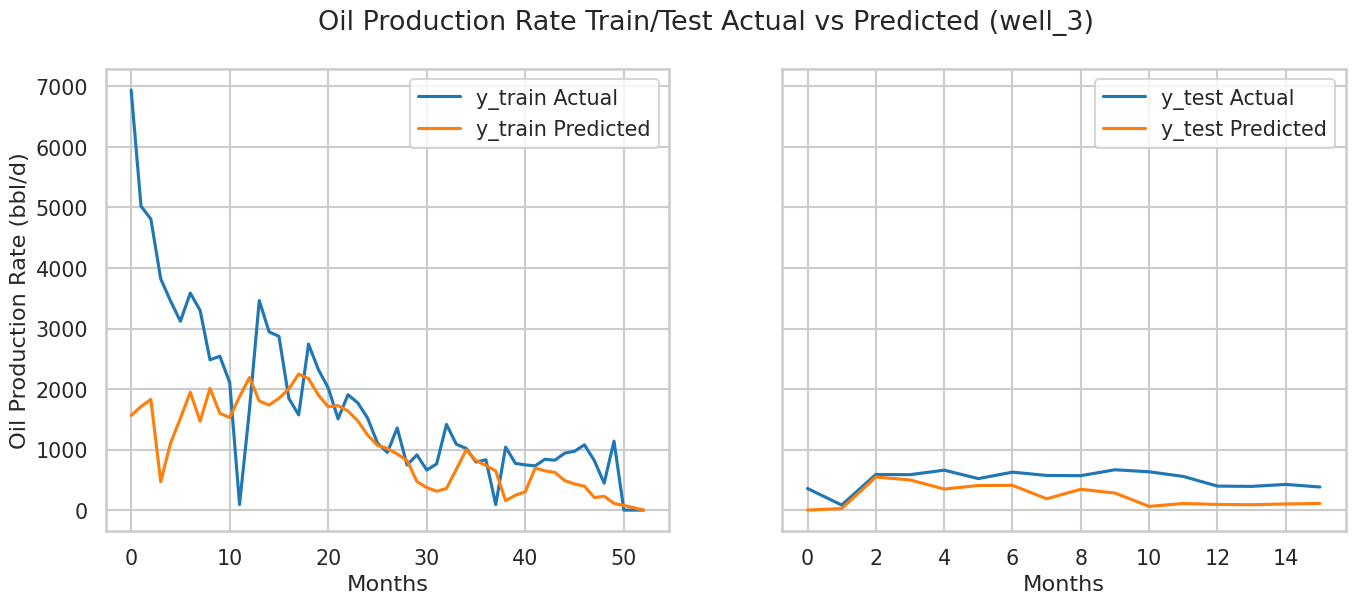

In [24]:
# Fit LSTM model and predict for well_3
predict_oil_production(train_test_dict, 'well_3', look_back, history)

#### Well 4 Base LSTM Prediction


Root Mean Squared Error Scores (well_4)

Train RMSE: 1,262.7
Test RMSE: 186.2


Actual vs Predicted Plots (well_4)



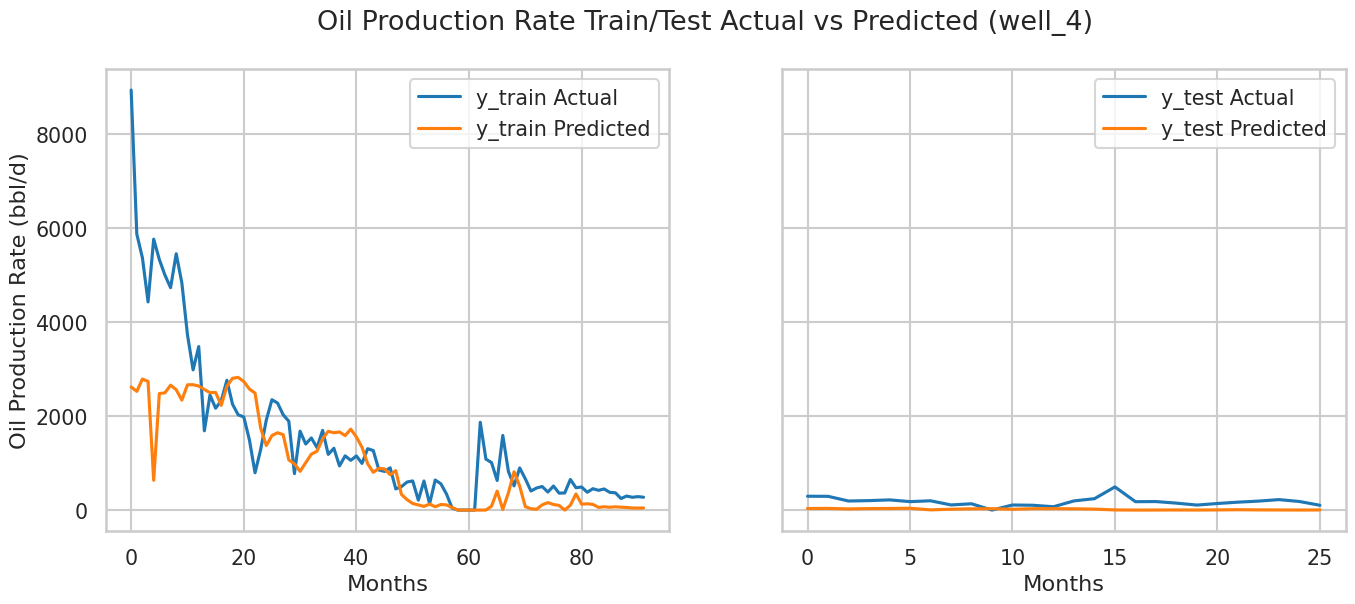

In [25]:
# Fit LSTM model and predict for well_4
predict_oil_production(train_test_dict, 'well_4', look_back, history)

#### Well 5 Base LSTM Prediction


Root Mean Squared Error Scores (well_5)

Train RMSE: 790.3
Test RMSE: 280.6


Actual vs Predicted Plots (well_5)



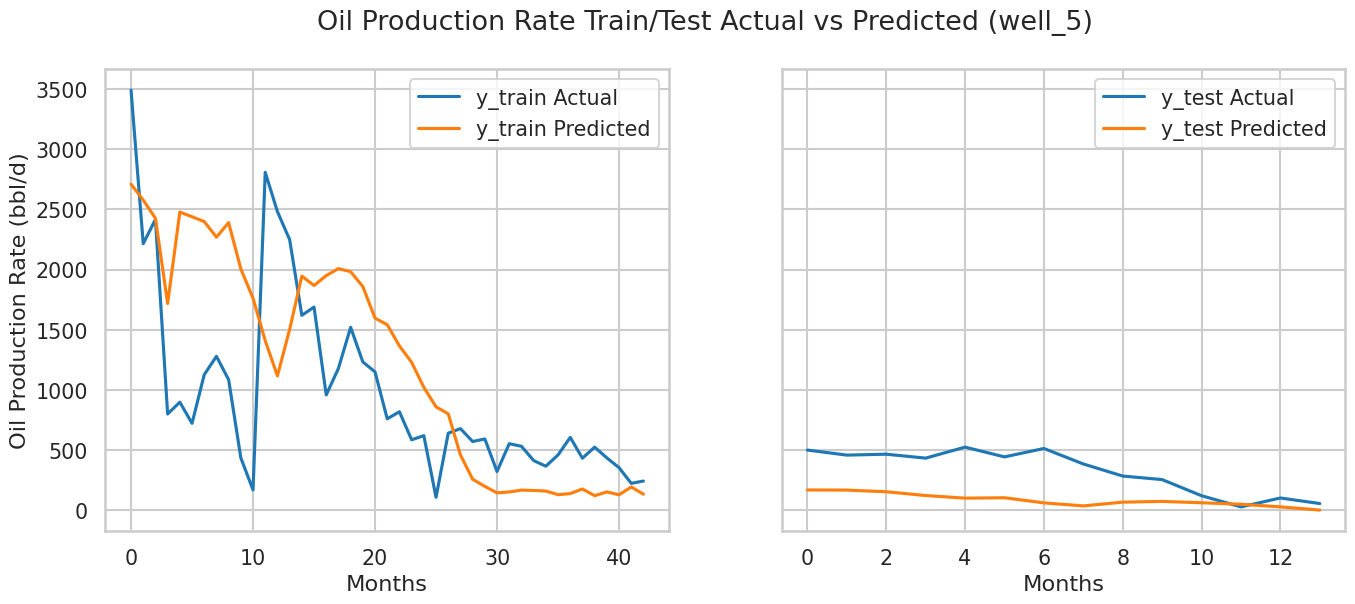

In [26]:
# Fit LSTM model and predict for well_5
predict_oil_production(train_test_dict, 'well_5', look_back, history)

> Something about base predictions

## HYPERPARAMETER TUNING
Using the selected model parameters of `lookback = 12`, `n_nodes = 4`, `learning_rate = 0.001`, and `dropout = 0.1` captured the general trends of the training data, but the fit could be improved. Next I'll tune the parameters using the Optuna bayesian optimizer to find the ideal model for each well.

#### Create Tuning Functions
- ...

In [27]:
# Directory to store per-trial trained models
MODEL_DIR = "optuna_lstm_models"
os.makedirs(MODEL_DIR, exist_ok=True)

# Function to evaluate a single hyperparameter tuning trial
def _evaluate_trial(model_type, trial, train_test_dict, well_name):
    # Define parameter ranges to test 
    look_back = trial.suggest_categorical('look_back', [12, 24, 36])
    n_nodes = trial.suggest_categorical('n_nodes', [4, 8, 16])
    learning_rate = trial.suggest_float('learning_rate', 1e-3, 0.5, log=True)
    dropout = trial.suggest_float('dropout', 0.0, 0.5, step=0.1)

    # Get X_train and y_train datasets based on the look_back window
    X_train = np.concatenate(
        [train_test_dict[well_name][look_back]['X_train'] for well_name in train_test_dict.keys()],
        axis=0
    )
    y_train = np.concatenate(
        [train_test_dict[well_name][look_back]['y_train'] for well_name in train_test_dict.keys()],
        axis=0
    )

    # Create an LSTM model instance for the selected hyperparameters
    model = create_LSTM_model(
        model_type,
        n_nodes,
        look_back,
        learning_rate,
        dropout,
        X_train.shape[2]
    )

    # Unique path for this trial's best model
    model_path = os.path.join(
        MODEL_DIR,
        f"{model_type}_{well_name}_trial_{trial.number}.keras"
    )

    # Callbacks: EarlyStopping + ModelCheckpoint for best val_loss
    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=PATIENCE,
        restore_best_weights=True
    )
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath=model_path,
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,
        verbose=0
    )

    # Fit LSTM model
    model.fit(
        X_train,
        y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=(1 - SPLIT_RATIO),
        shuffle=False,
        verbose=0,
        callbacks=[early_stopping, checkpoint],
    )

    # Define the per-well X_test and y_test datasets
    X_test = train_test_dict[well_name][look_back]['X_test']
    y_test = train_test_dict[well_name][look_back]['y_test']
    y_test = np.exp(y_test) - SCALING_FACTOR

    # IMPORTANT: load the saved best model for this trial and evaluate with it
    best_model = keras.models.load_model(model_path)
    testPredict = best_model.predict(X_test, verbose=0)
    testPredict = np.exp(testPredict) - SCALING_FACTOR

    # Calculate the RMSE using the y_test and testPredict values
    test_rmse = np.sqrt(mean_squared_error(y_test, testPredict))

    # Store hyperparameters and model path in the trial for later use
    trial.set_user_attr('look_back', look_back)
    trial.set_user_attr('n_nodes', n_nodes)
    trial.set_user_attr('learning_rate', learning_rate)
    trial.set_user_attr('dropout', dropout)
    trial.set_user_attr('model_path', model_path)

    # Clear keras session
    keras.backend.clear_session()

    # Display the results of the current trial
    print(
        f'(look_back={look_back}, n_nodes={n_nodes}, '
        f'learning_rate={learning_rate:.4f}, dropout={dropout:.4f}) '
        f'-> RMSE={test_rmse:.4f}'
    )

    return float(test_rmse)

# Function to apply Bayesian hyperparameter tuning using the Optuna package
def bayesian_tune_hyperparameters(model_type):
    # Check if hyperparameters have already been tuned and load from directory
    # (used to optimize re-runs of the worksheet)
    csv_path = f'tuning_rmse_results_{model_type}.csv'
    if os.path.exists(csv_path):
        return pd.read_csv(csv_path)
    else: 
        # If the hyperparameters have not been previously tuned then continue to tuning
        trial_records = []
        well_names = df['well_name'].unique()

        # Loop over the well_names and conduct tuning trials
        for well_name in well_names:
            print(f'{model_type} Model Bayesian optimization trials for {well_name}:')

            # Optuna objective function to optimize
            def objective(trial):
                return _evaluate_trial(model_type, trial, train_test_dict, well_name)
            
            # Create an Optuna study instance and run tuning trials
            study = optuna.create_study(direction='minimize')
            study.optimize(
                objective,
                n_trials=N_TRIALS,
                show_progress_bar=True,
                gc_after_trial=True
            )

            # Save information on all trials, including the stored model path
            trial_records.extend(
                [
                    {
                        'well_name': well_name,
                        'trial': trial.number,
                        'look_back': trial.params.get('look_back'),
                        'n_nodes': trial.params.get('n_nodes'),
                        'learning_rate': trial.params.get('learning_rate'),
                        'dropout': trial.params.get('dropout'),
                        'test_rmse': trial.value,
                        # model_path stored in user_attrs by _evaluate_trial
                        'model_path': trial.user_attrs.get('model_path'),
                    }
                    for trial in study.trials
                ]
            )

            # Create a parallel coordinate plot summarizing the tuning results
            parallel_fig = plot_parallel_coordinate(
                study,
                params=['look_back', 'n_nodes', 'learning_rate', 'dropout'],
                target=lambda t: t.value,
                target_name='RMSE'
            ).update_layout(
                title_text=(
                    'Hyperparameter Tuning Parallel Coordinate Plot - '
                    f'{well_name.replace("_"," ").title()}'
                )
            )
            display(parallel_fig)

        # Save the RMSE scores for each trial and return a dataframe of RMSE scores
        rmse_df = pd.DataFrame(trial_records)
        rmse_df.to_csv(csv_path, index=False)
        return rmse_df

# Run Optuna hyperparameter tuning for the Base LSTM model
base_rmse_df = bayesian_tune_hyperparameters(model_type)

base Model Bayesian optimization trials for well_1:


  0%|          | 0/30 [00:00<?, ?it/s]

(look_back=24, n_nodes=4, learning_rate=0.0025, dropout=0.0000) -> RMSE=453.9128
(look_back=36, n_nodes=8, learning_rate=0.0298, dropout=0.5000) -> RMSE=476.8040
(look_back=12, n_nodes=4, learning_rate=0.0051, dropout=0.1000) -> RMSE=490.5381
(look_back=12, n_nodes=4, learning_rate=0.2041, dropout=0.0000) -> RMSE=568.2917
(look_back=36, n_nodes=8, learning_rate=0.0011, dropout=0.0000) -> RMSE=469.2506
(look_back=12, n_nodes=16, learning_rate=0.4777, dropout=0.0000) -> RMSE=50551.0882
(look_back=24, n_nodes=4, learning_rate=0.0013, dropout=0.4000) -> RMSE=489.7874
(look_back=12, n_nodes=8, learning_rate=0.0504, dropout=0.4000) -> RMSE=482.7285
(look_back=12, n_nodes=8, learning_rate=0.0018, dropout=0.2000) -> RMSE=552.9464
(look_back=36, n_nodes=16, learning_rate=0.0015, dropout=0.1000) -> RMSE=399.9843
(look_back=36, n_nodes=16, learning_rate=0.0099, dropout=0.2000) -> RMSE=551.2552
(look_back=24, n_nodes=16, learning_rate=0.0037, dropout=0.1000) -> RMSE=480.8478
(look_back=24, n_nodes

base Model Bayesian optimization trials for well_2:


  0%|          | 0/30 [00:00<?, ?it/s]

(look_back=36, n_nodes=4, learning_rate=0.0014, dropout=0.5000) -> RMSE=114.1130
(look_back=12, n_nodes=4, learning_rate=0.2497, dropout=0.3000) -> RMSE=191.7454
(look_back=36, n_nodes=16, learning_rate=0.0030, dropout=0.4000) -> RMSE=89.2677
(look_back=36, n_nodes=4, learning_rate=0.0056, dropout=0.5000) -> RMSE=112.7214
(look_back=12, n_nodes=4, learning_rate=0.4570, dropout=0.3000) -> RMSE=8417.4425
(look_back=12, n_nodes=4, learning_rate=0.0048, dropout=0.0000) -> RMSE=121.8957
(look_back=12, n_nodes=4, learning_rate=0.0740, dropout=0.5000) -> RMSE=113.5003
(look_back=36, n_nodes=4, learning_rate=0.0014, dropout=0.1000) -> RMSE=116.2063
(look_back=12, n_nodes=16, learning_rate=0.0529, dropout=0.1000) -> RMSE=130.7156
(look_back=24, n_nodes=4, learning_rate=0.0316, dropout=0.1000) -> RMSE=117.5848
(look_back=24, n_nodes=8, learning_rate=0.0110, dropout=0.4000) -> RMSE=118.4038
(look_back=36, n_nodes=16, learning_rate=0.0056, dropout=0.4000) -> RMSE=163.2756
(look_back=36, n_nodes=16

base Model Bayesian optimization trials for well_3:


  0%|          | 0/30 [00:00<?, ?it/s]

(look_back=12, n_nodes=4, learning_rate=0.0076, dropout=0.2000) -> RMSE=446.9651
(look_back=24, n_nodes=8, learning_rate=0.1479, dropout=0.4000) -> RMSE=483.7811
(look_back=36, n_nodes=4, learning_rate=0.0040, dropout=0.0000) -> RMSE=324.7676
(look_back=36, n_nodes=16, learning_rate=0.3531, dropout=0.3000) -> RMSE=485.5353
(look_back=36, n_nodes=8, learning_rate=0.0158, dropout=0.2000) -> RMSE=1141.1286
(look_back=24, n_nodes=16, learning_rate=0.0245, dropout=0.1000) -> RMSE=476.1866
(look_back=24, n_nodes=8, learning_rate=0.0018, dropout=0.3000) -> RMSE=355.4974
(look_back=12, n_nodes=16, learning_rate=0.1518, dropout=0.0000) -> RMSE=3115.2949
(look_back=12, n_nodes=16, learning_rate=0.0792, dropout=0.3000) -> RMSE=722.7372
(look_back=36, n_nodes=4, learning_rate=0.2414, dropout=0.4000) -> RMSE=340.7036
(look_back=36, n_nodes=4, learning_rate=0.0014, dropout=0.0000) -> RMSE=340.3596
(look_back=36, n_nodes=4, learning_rate=0.0012, dropout=0.0000) -> RMSE=344.7939
(look_back=36, n_nodes

base Model Bayesian optimization trials for well_4:


  0%|          | 0/30 [00:00<?, ?it/s]

(look_back=12, n_nodes=8, learning_rate=0.0864, dropout=0.5000) -> RMSE=53624.1788
(look_back=24, n_nodes=4, learning_rate=0.0758, dropout=0.3000) -> RMSE=156.0277
(look_back=36, n_nodes=16, learning_rate=0.0596, dropout=0.3000) -> RMSE=157.9092
(look_back=12, n_nodes=16, learning_rate=0.0098, dropout=0.1000) -> RMSE=153.5051
(look_back=36, n_nodes=16, learning_rate=0.0052, dropout=0.0000) -> RMSE=264.4859
(look_back=24, n_nodes=8, learning_rate=0.0658, dropout=0.5000) -> RMSE=162.9248
(look_back=12, n_nodes=8, learning_rate=0.0924, dropout=0.5000) -> RMSE=115585.0094
(look_back=24, n_nodes=8, learning_rate=0.1410, dropout=0.2000) -> RMSE=1374.7633
(look_back=36, n_nodes=16, learning_rate=0.1767, dropout=0.5000) -> RMSE=19739.0733
(look_back=24, n_nodes=16, learning_rate=0.0037, dropout=0.5000) -> RMSE=191.5142
(look_back=12, n_nodes=4, learning_rate=0.0012, dropout=0.0000) -> RMSE=175.6147
(look_back=12, n_nodes=4, learning_rate=0.0171, dropout=0.2000) -> RMSE=191.2429
(look_back=24, 

base Model Bayesian optimization trials for well_5:


  0%|          | 0/30 [00:00<?, ?it/s]

(look_back=36, n_nodes=16, learning_rate=0.0731, dropout=0.0000) -> RMSE=1037.9487
(look_back=36, n_nodes=4, learning_rate=0.0042, dropout=0.2000) -> RMSE=215.2211
(look_back=12, n_nodes=8, learning_rate=0.0036, dropout=0.5000) -> RMSE=145.4355
(look_back=36, n_nodes=16, learning_rate=0.0011, dropout=0.4000) -> RMSE=316.0303
(look_back=36, n_nodes=4, learning_rate=0.0237, dropout=0.2000) -> RMSE=230.5562
(look_back=36, n_nodes=4, learning_rate=0.0262, dropout=0.2000) -> RMSE=208.7951
(look_back=24, n_nodes=8, learning_rate=0.0463, dropout=0.1000) -> RMSE=291.9344
(look_back=36, n_nodes=8, learning_rate=0.2037, dropout=0.2000) -> RMSE=185.2229
(look_back=24, n_nodes=16, learning_rate=0.0285, dropout=0.1000) -> RMSE=360.0173
(look_back=36, n_nodes=16, learning_rate=0.1386, dropout=0.2000) -> RMSE=346.7752
(look_back=12, n_nodes=8, learning_rate=0.0054, dropout=0.5000) -> RMSE=266.3771
(look_back=12, n_nodes=8, learning_rate=0.4582, dropout=0.4000) -> RMSE=203.3465
(look_back=12, n_nodes=

> something about base HP tuning results...

#### Boxplot of Hyperparameter Tuning RMSE Results
- What is this...
- Extreme outliers in `base_rmse_df` are hidden using a +/- 1.5 * IQR filter

In [28]:
# Function to filter outliers for each well using the 1.5*IQR rule
def rmse_iqr_filter(rmse_df):
    quartiles = rmse_df.groupby('well_name')['test_rmse'].quantile([0.25, 0.75]).unstack()
    quartiles.columns = ['q1', 'q3']
    quartiles['iqr'] = quartiles['q3'] - quartiles['q1']
    quartiles['lower'] = quartiles['q1'] - 1.5 * quartiles['iqr']
    quartiles['upper'] = quartiles['q3'] + 1.5 * quartiles['iqr']
    filtered_rmse_df = rmse_df.merge(quartiles[['lower', 'upper']], left_on='well_name', right_index=True)
    filtered_rmse_df = filtered_rmse_df[(filtered_rmse_df['test_rmse'] >= filtered_rmse_df['lower']) & (filtered_rmse_df['test_rmse'] <= filtered_rmse_df['upper'])]
    filtered_rmse_df = filtered_rmse_df.drop(columns=['lower', 'upper'])
    return filtered_rmse_df

# Function to create a set of boxplot to see the distribution of the RMSE scores attained in the hyperparameter tuning trials
def rmse_boxplots(rmse_df, model_type):
    # Filter rmse_df to remove outliers
    filtered_rmse_df = rmse_iqr_filter(rmse_df)
    
    # Boxplot showing RMSE variation by well
    rmse_boxplot = (
        alt.Chart(filtered_rmse_df)
        .mark_boxplot(size=130)
        .encode(
            x=alt.X('well_name:N', title='Well'),
            y=alt.Y('test_rmse:Q', title='Test RMSE'),
            color=alt.Color('well_name:N', legend=None)
        )
        .properties(
            width=800,
            height=400,
            title=alt.Title(
                f'{model_type} Model Hyperparameter Tuning RMSE Variation by Well',
                subtitle='Note: Extreme outliers have been hidden using a +/- 1.5 * IQR filter',
                fontSize=20,
                anchor='start'
            )
        )
    )
    return rmse_boxplot

# Create boxplots summarizing the Base LSTM model's RMSE tuning results
rmse_boxplots(base_rmse_df, 'Base')

alt.Chart(...)

> Something about base RMSE boxplots...

#### Apply Best Hyperparameters
- Hyperparameters are applied based on the best RMSE score for each well
- Since model is being refit after hyperparameter tuning the train and test RMSE values may stochastically vary from what Optuna produces

Best hyperparameters for well_1:
    look_back = 36
    n_nodes = 16
    learning_rate = 0.0162
    dropout = 0.5000
Loading best Optuna model from: optuna_lstm_models/base_well_1_trial_20.keras

Root Mean Squared Error Scores (well_1)

Train RMSE: 378.5
Test RMSE: 366.8


Actual vs Predicted Plots (well_1)



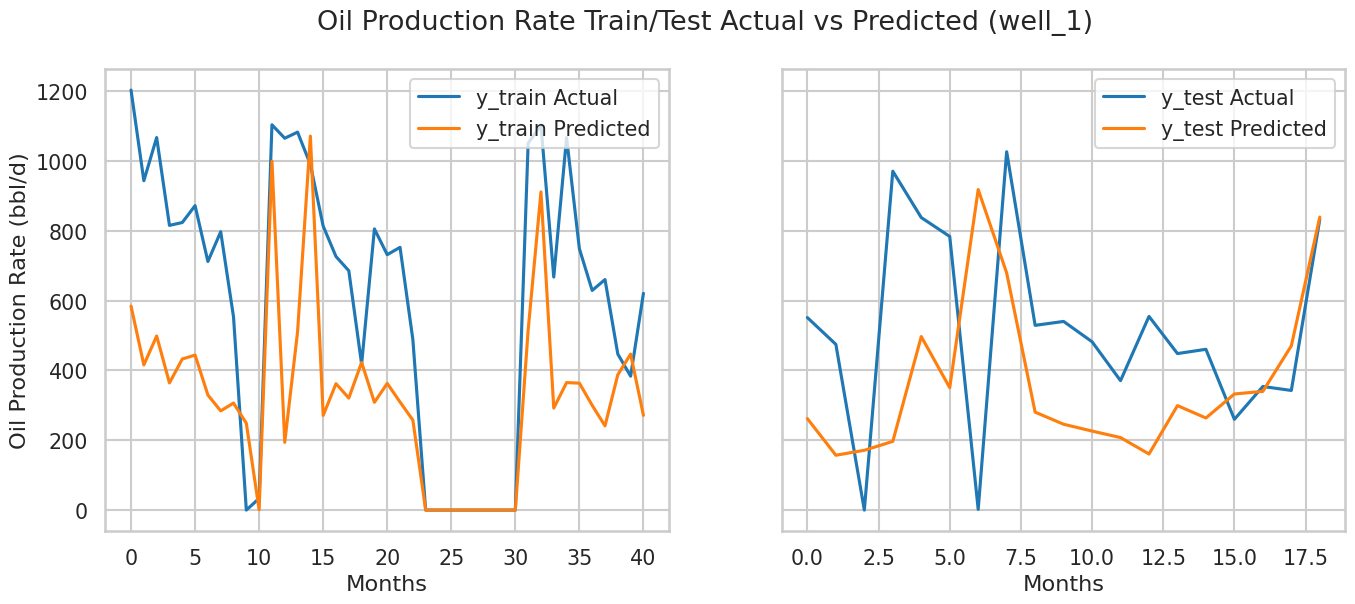

In [29]:
# Function to fit and predict an LSTM model using the best hyperparameter tuning
# results for each well, now loading the exact best Optuna-trained model if available.
def apply_best_hyperparameters(rmse_df, train_test_dict, well_name, model_type):
    # Find the set of best hyperparameters
    best_entry = (
        rmse_df[rmse_df['well_name'] == well_name]
        .sort_values('test_rmse')
        .iloc[0]
    )

    # Extract the best hyperparameters (for logging / inspection)
    look_back = int(best_entry['look_back'])
    n_nodes = int(best_entry['n_nodes'])
    learning_rate = float(best_entry['learning_rate'])
    dropout = float(best_entry['dropout'])
    model_path = best_entry.get('model_path', None)

    print(
        f'Best hyperparameters for {well_name}:\n'
        f'    look_back = {look_back}\n'
        f'    n_nodes = {n_nodes}\n'
        f'    learning_rate = {learning_rate:.4f}\n'
        f'    dropout = {dropout:.4f}'
    )

    # If we have a saved model path from Optuna and the file exists,
    # load and use that *exact* model.
    if isinstance(model_path, str) and os.path.exists(model_path):
        print(f'Loading best Optuna model from: {model_path}')
        best_model = keras.models.load_model(model_path)

        # Wrap loaded model in a minimal History-like object so that
        # existing `predict_oil_production(..., history)` code that calls
        # `history.model.predict(...)` continues to work unchanged.
        class DummyHistory:
            def __init__(self, model):
                self.model = model
                self.history = {}

        history = DummyHistory(best_model)

        # Use the loaded best model for prediction / plotting
        predict_oil_production(train_test_dict, well_name, look_back, history)

    else:
        # Fallback: if model_path is missing (e.g., old CSV) or file is gone,
        # recreate and refit the model using the best hyperparameters.
        print(
            'Saved model path not available; refitting model with best hyperparameters.'
        )

        # Create X_train and y_train datasets for the given look_back window
        X_train = np.concatenate(
            [train_test_dict[well_name][look_back]['X_train'] for well_name in train_test_dict.keys()],
            axis=0
        )
        y_train = np.concatenate(
            [train_test_dict[well_name][look_back]['y_train'] for well_name in train_test_dict.keys()],
            axis=0
        )

        # Create an LSTM model instance for the given best hyperparameters
        model = create_LSTM_model(
            model_type,
            n_nodes,
            look_back,
            learning_rate,
            dropout,
            X_train.shape[2]
        )

        # Fit the LSTM model using your existing helper
        history = fit_lstm(model)

        # Predict and visualize using the freshly trained model
        predict_oil_production(train_test_dict, well_name, look_back, history)

apply_best_hyperparameters(base_rmse_df, train_test_dict, 'well_1', 'base')

Best hyperparameters for well_2:
    look_back = 36
    n_nodes = 16
    learning_rate = 0.0030
    dropout = 0.4000
Loading best Optuna model from: optuna_lstm_models/base_well_2_trial_2.keras

Root Mean Squared Error Scores (well_2)

Train RMSE: 599.6
Test RMSE: 89.3


Actual vs Predicted Plots (well_2)



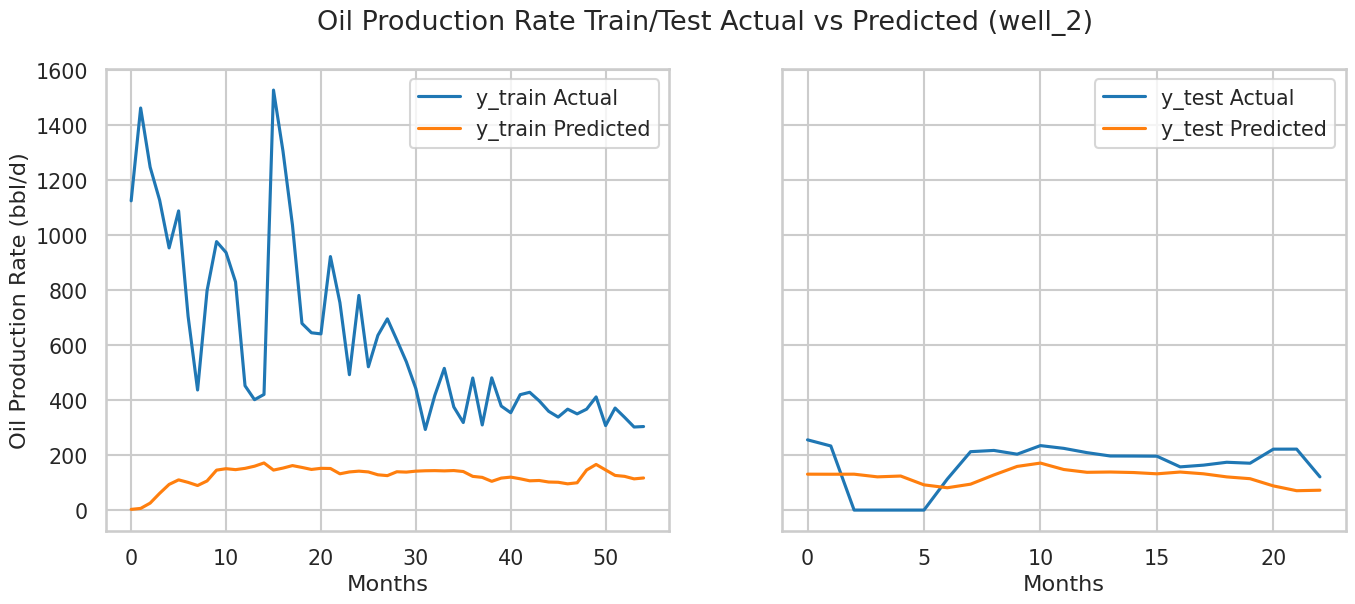

In [30]:
# Apply best base tuned hyperparameters to Well 2
apply_best_hyperparameters(base_rmse_df, train_test_dict, 'well_2', 'base')

Best hyperparameters for well_3:
    look_back = 12
    n_nodes = 4
    learning_rate = 0.0023
    dropout = 0.0000
Loading best Optuna model from: optuna_lstm_models/base_well_3_trial_23.keras

Root Mean Squared Error Scores (well_3)

Train RMSE: 1,021.6
Test RMSE: 278.4


Actual vs Predicted Plots (well_3)



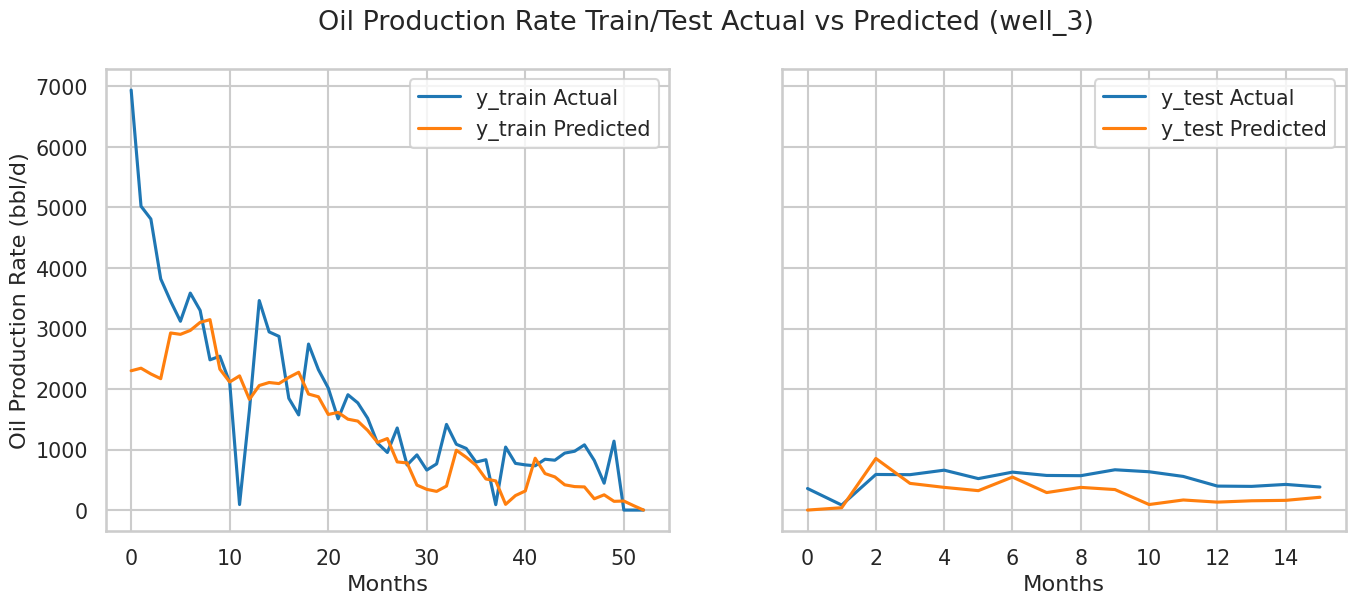

In [31]:
# Apply best base tuned hyperparameters to Well 3
apply_best_hyperparameters(base_rmse_df, train_test_dict, 'well_3', 'base')

Best hyperparameters for well_4:
    look_back = 24
    n_nodes = 4
    learning_rate = 0.0265
    dropout = 0.4000
Loading best Optuna model from: optuna_lstm_models/base_well_4_trial_15.keras

Root Mean Squared Error Scores (well_4)

Train RMSE: 1,253.6
Test RMSE: 122.0


Actual vs Predicted Plots (well_4)



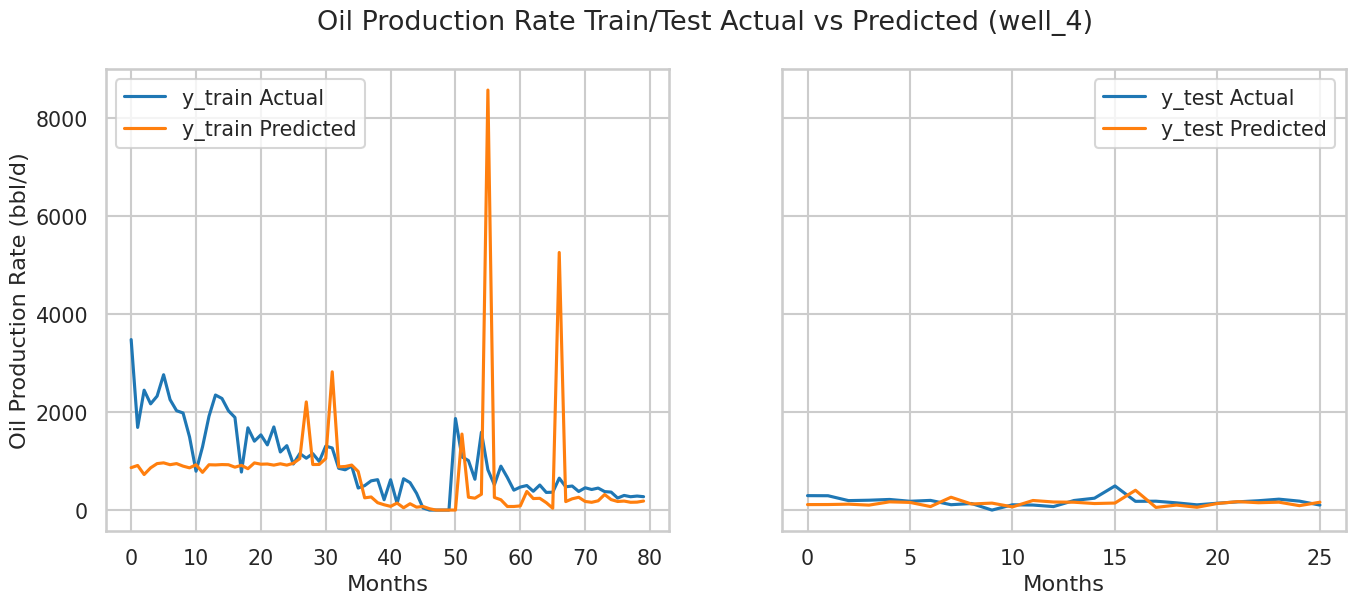

In [32]:
# Apply best base tuned hyperparameters to Well 4
apply_best_hyperparameters(base_rmse_df, train_test_dict, 'well_4', 'base')

Best hyperparameters for well_5:
    look_back = 12
    n_nodes = 8
    learning_rate = 0.0036
    dropout = 0.5000
Loading best Optuna model from: optuna_lstm_models/base_well_5_trial_2.keras

Root Mean Squared Error Scores (well_5)

Train RMSE: 793.6
Test RMSE: 145.4


Actual vs Predicted Plots (well_5)



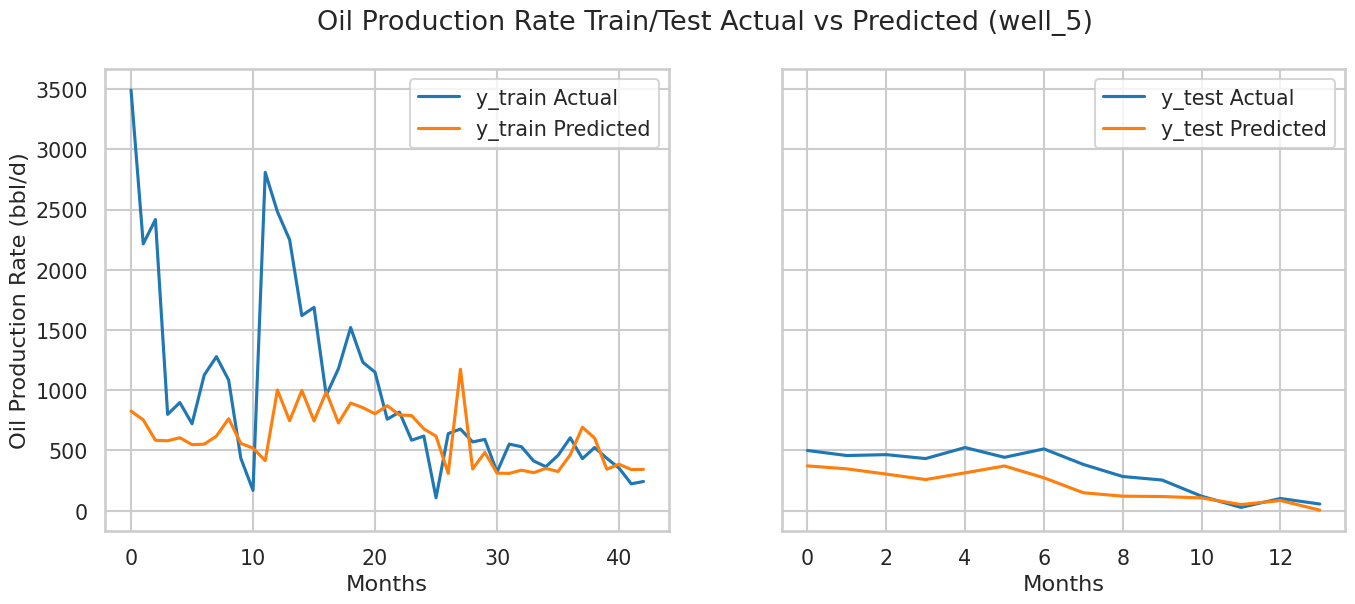

In [33]:
# Apply best base tuned hyperparameters to Well 5
apply_best_hyperparameters(base_rmse_df, train_test_dict, 'well_5', 'base')

> Something about applying best HP to base...

## ALTERNATIVE LSTM MODELS
- Bidirectional LSTM
- Stacked LSTM
- CNN-LSTM

#### Bidirectional LSTM
- describe ...

In [34]:
# Create tuned Bidirectional LSTM models
model_type = 'bidirectional'
bidirectional_rmse_df = bayesian_tune_hyperparameters(model_type)

bidirectional Model Bayesian optimization trials for well_1:


  0%|          | 0/30 [00:00<?, ?it/s]

(look_back=36, n_nodes=16, learning_rate=0.0142, dropout=0.2000) -> RMSE=513.6369
(look_back=12, n_nodes=4, learning_rate=0.0137, dropout=0.1000) -> RMSE=487.3593
(look_back=12, n_nodes=8, learning_rate=0.0025, dropout=0.2000) -> RMSE=482.0587
(look_back=36, n_nodes=8, learning_rate=0.0290, dropout=0.5000) -> RMSE=471.4315
(look_back=12, n_nodes=8, learning_rate=0.0377, dropout=0.3000) -> RMSE=388.3096
(look_back=24, n_nodes=4, learning_rate=0.0143, dropout=0.3000) -> RMSE=509.1648
(look_back=12, n_nodes=8, learning_rate=0.0107, dropout=0.5000) -> RMSE=420.4610
(look_back=36, n_nodes=16, learning_rate=0.0329, dropout=0.4000) -> RMSE=349.7124
(look_back=24, n_nodes=4, learning_rate=0.0042, dropout=0.3000) -> RMSE=543.2654
(look_back=24, n_nodes=4, learning_rate=0.0011, dropout=0.3000) -> RMSE=412.3083
(look_back=36, n_nodes=16, learning_rate=0.2623, dropout=0.0000) -> RMSE=553.9931
(look_back=12, n_nodes=16, learning_rate=0.0815, dropout=0.4000) -> RMSE=552.6209
(look_back=36, n_nodes=1

bidirectional Model Bayesian optimization trials for well_2:


  0%|          | 0/30 [00:00<?, ?it/s]

(look_back=12, n_nodes=8, learning_rate=0.0045, dropout=0.5000) -> RMSE=142.9367
(look_back=24, n_nodes=8, learning_rate=0.0012, dropout=0.3000) -> RMSE=212.6493
(look_back=24, n_nodes=16, learning_rate=0.0782, dropout=0.2000) -> RMSE=172.7699
(look_back=36, n_nodes=4, learning_rate=0.0035, dropout=0.1000) -> RMSE=103.6510
(look_back=36, n_nodes=4, learning_rate=0.0080, dropout=0.0000) -> RMSE=150.9669
(look_back=24, n_nodes=16, learning_rate=0.0173, dropout=0.3000) -> RMSE=127.0648
(look_back=12, n_nodes=4, learning_rate=0.0437, dropout=0.0000) -> RMSE=141.6610
(look_back=36, n_nodes=16, learning_rate=0.0016, dropout=0.0000) -> RMSE=153.7401
(look_back=24, n_nodes=16, learning_rate=0.0844, dropout=0.5000) -> RMSE=155.7980
(look_back=36, n_nodes=8, learning_rate=0.3581, dropout=0.4000) -> RMSE=466.7782
(look_back=36, n_nodes=4, learning_rate=0.0042, dropout=0.1000) -> RMSE=126.9437
(look_back=36, n_nodes=4, learning_rate=0.0039, dropout=0.1000) -> RMSE=135.8714
(look_back=36, n_nodes=4

bidirectional Model Bayesian optimization trials for well_3:


  0%|          | 0/30 [00:00<?, ?it/s]

(look_back=12, n_nodes=16, learning_rate=0.0399, dropout=0.2000) -> RMSE=479.2958
(look_back=24, n_nodes=16, learning_rate=0.0072, dropout=0.3000) -> RMSE=1477.3323
(look_back=12, n_nodes=4, learning_rate=0.0711, dropout=0.2000) -> RMSE=512.4214
(look_back=36, n_nodes=4, learning_rate=0.2426, dropout=0.5000) -> RMSE=1532.8557
(look_back=12, n_nodes=4, learning_rate=0.0023, dropout=0.1000) -> RMSE=356.7698
(look_back=36, n_nodes=16, learning_rate=0.0012, dropout=0.4000) -> RMSE=512.9979
(look_back=12, n_nodes=4, learning_rate=0.0016, dropout=0.1000) -> RMSE=379.6308
(look_back=24, n_nodes=8, learning_rate=0.0366, dropout=0.5000) -> RMSE=364.3592
(look_back=36, n_nodes=4, learning_rate=0.3878, dropout=0.2000) -> RMSE=474.4296
(look_back=24, n_nodes=4, learning_rate=0.1276, dropout=0.4000) -> RMSE=426.0202
(look_back=12, n_nodes=8, learning_rate=0.0071, dropout=0.0000) -> RMSE=431.4008
(look_back=24, n_nodes=8, learning_rate=0.0140, dropout=0.0000) -> RMSE=384.1571
(look_back=24, n_nodes=

bidirectional Model Bayesian optimization trials for well_4:


  0%|          | 0/30 [00:00<?, ?it/s]

(look_back=24, n_nodes=4, learning_rate=0.0011, dropout=0.1000) -> RMSE=196.1188
(look_back=36, n_nodes=4, learning_rate=0.0014, dropout=0.3000) -> RMSE=166.2911
(look_back=12, n_nodes=4, learning_rate=0.0063, dropout=0.4000) -> RMSE=170.0813
(look_back=12, n_nodes=4, learning_rate=0.0030, dropout=0.1000) -> RMSE=151.9477
(look_back=24, n_nodes=4, learning_rate=0.3668, dropout=0.4000) -> RMSE=194.1574
(look_back=12, n_nodes=8, learning_rate=0.2338, dropout=0.1000) -> RMSE=171.2692
(look_back=24, n_nodes=4, learning_rate=0.0332, dropout=0.4000) -> RMSE=170.9089
(look_back=24, n_nodes=4, learning_rate=0.0107, dropout=0.0000) -> RMSE=184.6560
(look_back=36, n_nodes=16, learning_rate=0.0672, dropout=0.3000) -> RMSE=170.2868
(look_back=24, n_nodes=8, learning_rate=0.0143, dropout=0.2000) -> RMSE=205.3493
(look_back=12, n_nodes=16, learning_rate=0.0036, dropout=0.0000) -> RMSE=234.7817
(look_back=36, n_nodes=4, learning_rate=0.0010, dropout=0.2000) -> RMSE=155.1285
(look_back=36, n_nodes=4, 

bidirectional Model Bayesian optimization trials for well_5:


  0%|          | 0/30 [00:00<?, ?it/s]

(look_back=36, n_nodes=16, learning_rate=0.1580, dropout=0.2000) -> RMSE=336.8250
(look_back=24, n_nodes=16, learning_rate=0.0043, dropout=0.5000) -> RMSE=292.3448
(look_back=12, n_nodes=4, learning_rate=0.3133, dropout=0.3000) -> RMSE=209.6666
(look_back=36, n_nodes=8, learning_rate=0.0684, dropout=0.4000) -> RMSE=285.7802
(look_back=12, n_nodes=4, learning_rate=0.1370, dropout=0.2000) -> RMSE=332.3953
(look_back=36, n_nodes=8, learning_rate=0.0420, dropout=0.2000) -> RMSE=315.4940
(look_back=24, n_nodes=16, learning_rate=0.0027, dropout=0.4000) -> RMSE=231.4669
(look_back=12, n_nodes=16, learning_rate=0.0150, dropout=0.5000) -> RMSE=312.6248
(look_back=36, n_nodes=16, learning_rate=0.0551, dropout=0.2000) -> RMSE=309.0535
(look_back=36, n_nodes=8, learning_rate=0.0584, dropout=0.4000) -> RMSE=309.1007
(look_back=12, n_nodes=4, learning_rate=0.4503, dropout=0.0000) -> RMSE=310.7294
(look_back=24, n_nodes=4, learning_rate=0.0023, dropout=0.3000) -> RMSE=265.6272
(look_back=24, n_nodes=

> something about HP tuning results...

In [35]:
# Display RMSE distributions
rmse_boxplots(bidirectional_rmse_df, model_type)

alt.Chart(...)

> something about boxplots...

Best hyperparameters for well_1:
    look_back = 36
    n_nodes = 16
    learning_rate = 0.0329
    dropout = 0.4000
Loading best Optuna model from: optuna_lstm_models/bidirectional_well_1_trial_7.keras

Root Mean Squared Error Scores (well_1)

Train RMSE: 405.0
Test RMSE: 349.7


Actual vs Predicted Plots (well_1)



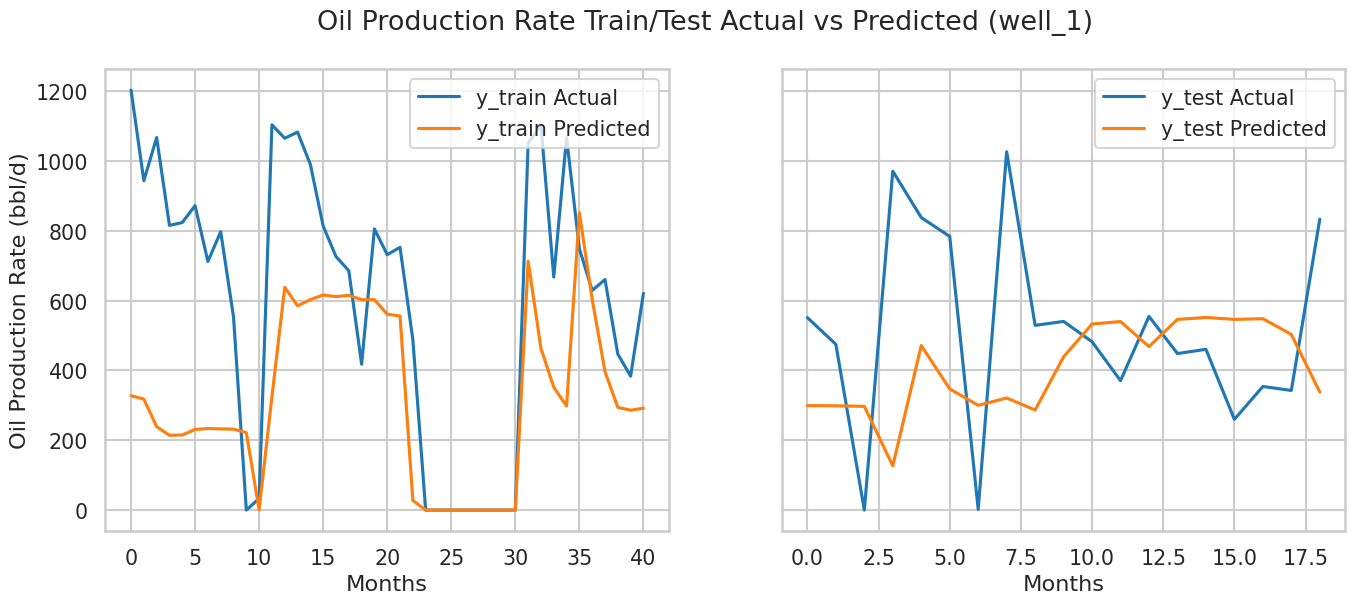

In [36]:
# Apply best Bidirectional LSTM tuned hyperparameters to Well 1
apply_best_hyperparameters(bidirectional_rmse_df, train_test_dict, 'well_1', model_type)

Best hyperparameters for well_2:
    look_back = 36
    n_nodes = 4
    learning_rate = 0.0035
    dropout = 0.1000
Loading best Optuna model from: optuna_lstm_models/bidirectional_well_2_trial_3.keras

Root Mean Squared Error Scores (well_2)

Train RMSE: 1,001.9
Test RMSE: 103.7


Actual vs Predicted Plots (well_2)



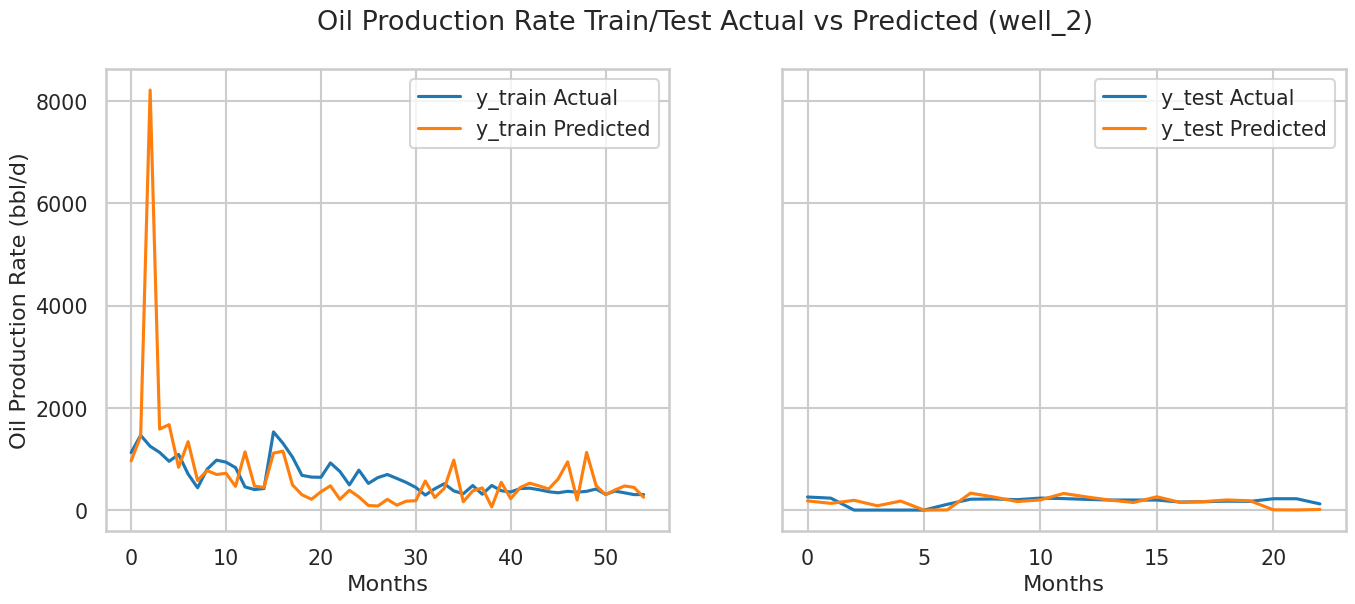

In [37]:
# Apply best Bidirectional LSTM tuned hyperparameters to Well 2
apply_best_hyperparameters(bidirectional_rmse_df, train_test_dict, 'well_2', model_type)

Best hyperparameters for well_3:
    look_back = 12
    n_nodes = 4
    learning_rate = 0.0885
    dropout = 0.1000
Loading best Optuna model from: optuna_lstm_models/bidirectional_well_3_trial_19.keras

Root Mean Squared Error Scores (well_3)

Train RMSE: 1,572.7
Test RMSE: 254.8


Actual vs Predicted Plots (well_3)



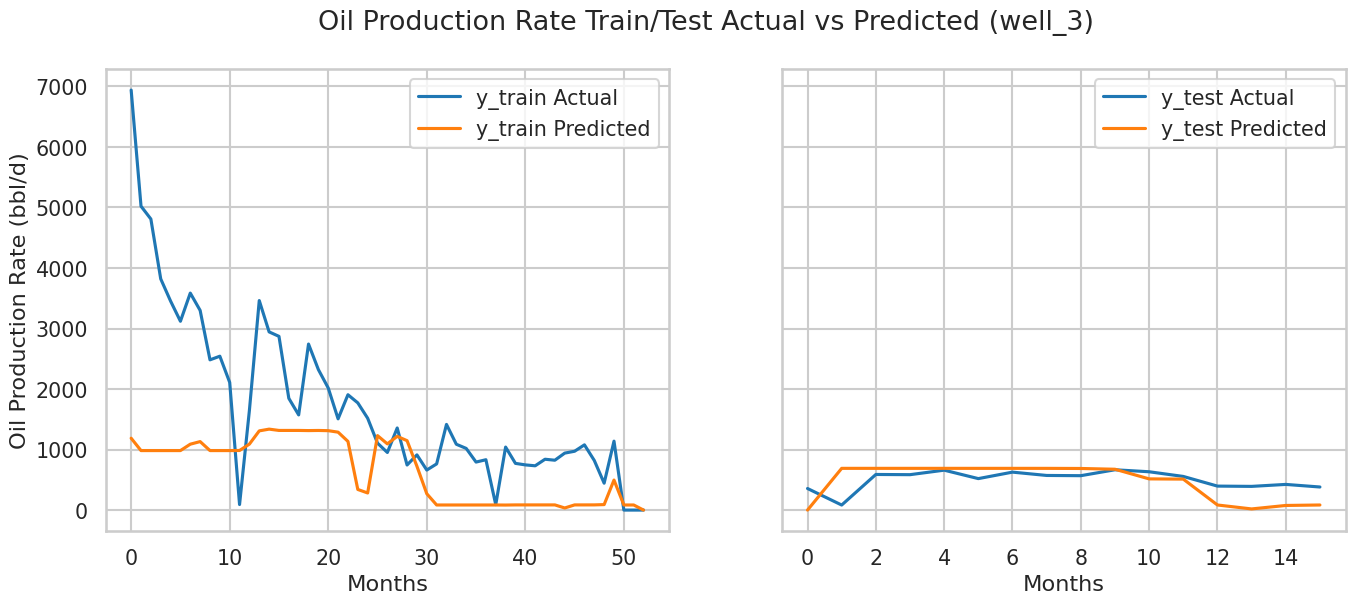

In [38]:
# Apply best Bidirectional LSTM tuned hyperparameters to Well 3
apply_best_hyperparameters(bidirectional_rmse_df, train_test_dict, 'well_3', model_type)

Best hyperparameters for well_4:
    look_back = 36
    n_nodes = 8
    learning_rate = 0.0016
    dropout = 0.1000
Loading best Optuna model from: optuna_lstm_models/bidirectional_well_4_trial_29.keras

Root Mean Squared Error Scores (well_4)

Train RMSE: 631.3
Test RMSE: 133.8


Actual vs Predicted Plots (well_4)



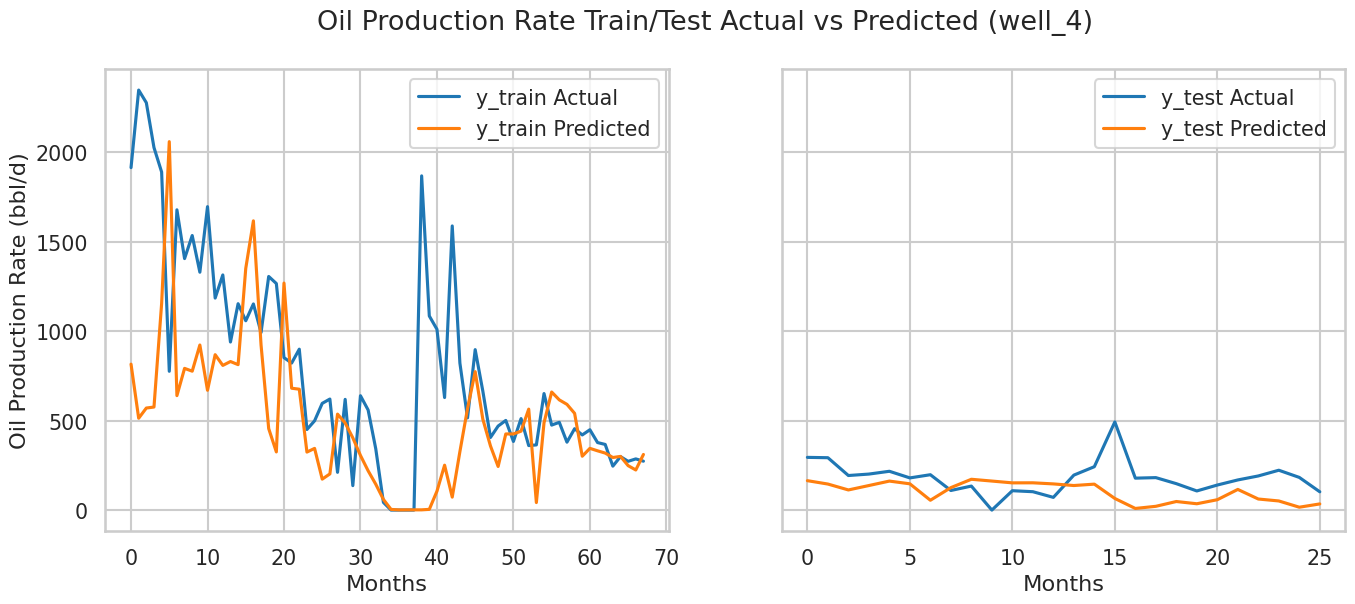

In [39]:
# Apply best Bidirectional LSTM tuned hyperparameters to Well 4
apply_best_hyperparameters(bidirectional_rmse_df, train_test_dict, 'well_4', model_type)

Best hyperparameters for well_5:
    look_back = 12
    n_nodes = 4
    learning_rate = 0.4448
    dropout = 0.3000
Loading best Optuna model from: optuna_lstm_models/bidirectional_well_5_trial_16.keras

Root Mean Squared Error Scores (well_5)

Train RMSE: 899.7
Test RMSE: 160.9


Actual vs Predicted Plots (well_5)



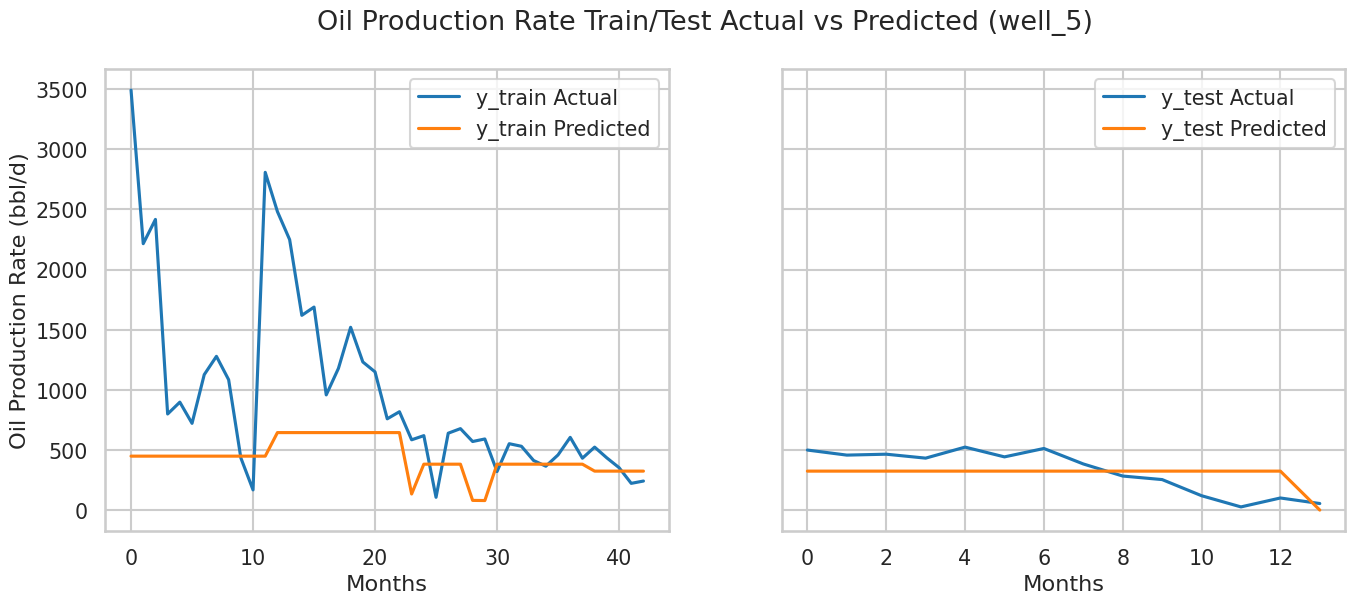

In [40]:
# Apply best Bidirectional LSTM tuned hyperparameters to Well 5
apply_best_hyperparameters(bidirectional_rmse_df, train_test_dict, 'well_5', model_type)

> Something about best HPs...

#### Stacked LSTM
- describe ...

In [41]:
# Create tuned Stacked LSTM models
model_type = 'stacked'
stacked_rmse_df = bayesian_tune_hyperparameters(model_type)

stacked Model Bayesian optimization trials for well_1:


  0%|          | 0/30 [00:00<?, ?it/s]

(look_back=12, n_nodes=8, learning_rate=0.0081, dropout=0.5000) -> RMSE=415.5956
(look_back=36, n_nodes=8, learning_rate=0.0023, dropout=0.2000) -> RMSE=337.8432
(look_back=24, n_nodes=4, learning_rate=0.0397, dropout=0.0000) -> RMSE=561.7429
(look_back=24, n_nodes=16, learning_rate=0.0017, dropout=0.4000) -> RMSE=352.6609
(look_back=24, n_nodes=16, learning_rate=0.0691, dropout=0.2000) -> RMSE=447.1209
(look_back=24, n_nodes=8, learning_rate=0.0010, dropout=0.2000) -> RMSE=458.8021
(look_back=12, n_nodes=8, learning_rate=0.0012, dropout=0.3000) -> RMSE=486.2512
(look_back=12, n_nodes=4, learning_rate=0.2868, dropout=0.2000) -> RMSE=531.3095
(look_back=24, n_nodes=16, learning_rate=0.0245, dropout=0.3000) -> RMSE=435.7785
(look_back=12, n_nodes=16, learning_rate=0.0107, dropout=0.5000) -> RMSE=295.6280
(look_back=36, n_nodes=16, learning_rate=0.0064, dropout=0.5000) -> RMSE=473.1053
(look_back=36, n_nodes=8, learning_rate=0.0054, dropout=0.0000) -> RMSE=545.9061
(look_back=36, n_nodes=

stacked Model Bayesian optimization trials for well_2:


  0%|          | 0/30 [00:00<?, ?it/s]

(look_back=36, n_nodes=8, learning_rate=0.0011, dropout=0.1000) -> RMSE=398.1920
(look_back=36, n_nodes=4, learning_rate=0.0025, dropout=0.0000) -> RMSE=391.0266
(look_back=12, n_nodes=16, learning_rate=0.1540, dropout=0.4000) -> RMSE=151.1296
(look_back=24, n_nodes=8, learning_rate=0.3267, dropout=0.4000) -> RMSE=178.3072
(look_back=12, n_nodes=8, learning_rate=0.4806, dropout=0.5000) -> RMSE=180.8285
(look_back=36, n_nodes=4, learning_rate=0.0211, dropout=0.0000) -> RMSE=111.2587
(look_back=36, n_nodes=4, learning_rate=0.0115, dropout=0.3000) -> RMSE=119.6964
(look_back=36, n_nodes=8, learning_rate=0.0147, dropout=0.2000) -> RMSE=266.0099
(look_back=12, n_nodes=16, learning_rate=0.0229, dropout=0.5000) -> RMSE=259.5397
(look_back=36, n_nodes=16, learning_rate=0.0019, dropout=0.1000) -> RMSE=84.9007
(look_back=24, n_nodes=16, learning_rate=0.0042, dropout=0.2000) -> RMSE=333.0540
(look_back=36, n_nodes=4, learning_rate=0.0657, dropout=0.0000) -> RMSE=359.8004
(look_back=36, n_nodes=16

stacked Model Bayesian optimization trials for well_3:


  0%|          | 0/30 [00:00<?, ?it/s]

(look_back=36, n_nodes=8, learning_rate=0.0074, dropout=0.2000) -> RMSE=165.6151
(look_back=12, n_nodes=16, learning_rate=0.0074, dropout=0.1000) -> RMSE=510.3648
(look_back=24, n_nodes=16, learning_rate=0.2833, dropout=0.0000) -> RMSE=521.9936
(look_back=36, n_nodes=4, learning_rate=0.3914, dropout=0.3000) -> RMSE=514.5329
(look_back=36, n_nodes=8, learning_rate=0.0051, dropout=0.3000) -> RMSE=246.4336
(look_back=24, n_nodes=8, learning_rate=0.0080, dropout=0.3000) -> RMSE=256.4307
(look_back=24, n_nodes=4, learning_rate=0.0011, dropout=0.5000) -> RMSE=382.8064
(look_back=36, n_nodes=8, learning_rate=0.0039, dropout=0.2000) -> RMSE=389.5922
(look_back=24, n_nodes=4, learning_rate=0.0016, dropout=0.4000) -> RMSE=169.4888
(look_back=12, n_nodes=16, learning_rate=0.0025, dropout=0.4000) -> RMSE=364.0363
(look_back=36, n_nodes=8, learning_rate=0.0535, dropout=0.1000) -> RMSE=435.3347
(look_back=24, n_nodes=4, learning_rate=0.0284, dropout=0.5000) -> RMSE=510.1699
(look_back=36, n_nodes=4,

stacked Model Bayesian optimization trials for well_4:


  0%|          | 0/30 [00:00<?, ?it/s]

(look_back=12, n_nodes=8, learning_rate=0.1440, dropout=0.0000) -> RMSE=318.3381
(look_back=24, n_nodes=16, learning_rate=0.1578, dropout=0.3000) -> RMSE=197.7994
(look_back=12, n_nodes=8, learning_rate=0.0014, dropout=0.5000) -> RMSE=164.1449
(look_back=12, n_nodes=8, learning_rate=0.0028, dropout=0.2000) -> RMSE=212.3195
(look_back=36, n_nodes=4, learning_rate=0.1322, dropout=0.2000) -> RMSE=158.0320
(look_back=24, n_nodes=8, learning_rate=0.1232, dropout=0.0000) -> RMSE=1233.5243
(look_back=36, n_nodes=16, learning_rate=0.0871, dropout=0.5000) -> RMSE=138.2880
(look_back=24, n_nodes=16, learning_rate=0.1411, dropout=0.3000) -> RMSE=198.9727
(look_back=12, n_nodes=8, learning_rate=0.2074, dropout=0.5000) -> RMSE=98.4709
(look_back=24, n_nodes=16, learning_rate=0.0275, dropout=0.3000) -> RMSE=165.5013
(look_back=12, n_nodes=4, learning_rate=0.0122, dropout=0.4000) -> RMSE=270.1791
(look_back=36, n_nodes=16, learning_rate=0.4106, dropout=0.5000) -> RMSE=127.0235
(look_back=36, n_nodes=

stacked Model Bayesian optimization trials for well_5:


  0%|          | 0/30 [00:00<?, ?it/s]

(look_back=12, n_nodes=16, learning_rate=0.0015, dropout=0.2000) -> RMSE=172.8936
(look_back=24, n_nodes=16, learning_rate=0.0100, dropout=0.2000) -> RMSE=240.0161
(look_back=36, n_nodes=4, learning_rate=0.0150, dropout=0.0000) -> RMSE=177.6979
(look_back=36, n_nodes=8, learning_rate=0.0461, dropout=0.1000) -> RMSE=280.7632
(look_back=12, n_nodes=8, learning_rate=0.0014, dropout=0.1000) -> RMSE=297.3794
(look_back=24, n_nodes=16, learning_rate=0.0381, dropout=0.4000) -> RMSE=282.3200
(look_back=36, n_nodes=4, learning_rate=0.0868, dropout=0.4000) -> RMSE=179.0240
(look_back=36, n_nodes=8, learning_rate=0.0022, dropout=0.1000) -> RMSE=281.0544
(look_back=24, n_nodes=8, learning_rate=0.0729, dropout=0.2000) -> RMSE=310.1084
(look_back=12, n_nodes=16, learning_rate=0.0030, dropout=0.4000) -> RMSE=187.2174
(look_back=12, n_nodes=16, learning_rate=0.2094, dropout=0.5000) -> RMSE=368.4871
(look_back=12, n_nodes=4, learning_rate=0.0083, dropout=0.0000) -> RMSE=199.7442
(look_back=36, n_nodes=

> something about HP tuning results...

In [42]:
# Display RMSE distributions
rmse_boxplots(stacked_rmse_df, model_type)

alt.Chart(...)

> something about boxplots...

Best hyperparameters for well_1:
    look_back = 36
    n_nodes = 8
    learning_rate = 0.0145
    dropout = 0.4000
Loading best Optuna model from: optuna_lstm_models/stacked_well_1_trial_13.keras

Root Mean Squared Error Scores (well_1)

Train RMSE: 389.1
Test RMSE: 293.2


Actual vs Predicted Plots (well_1)



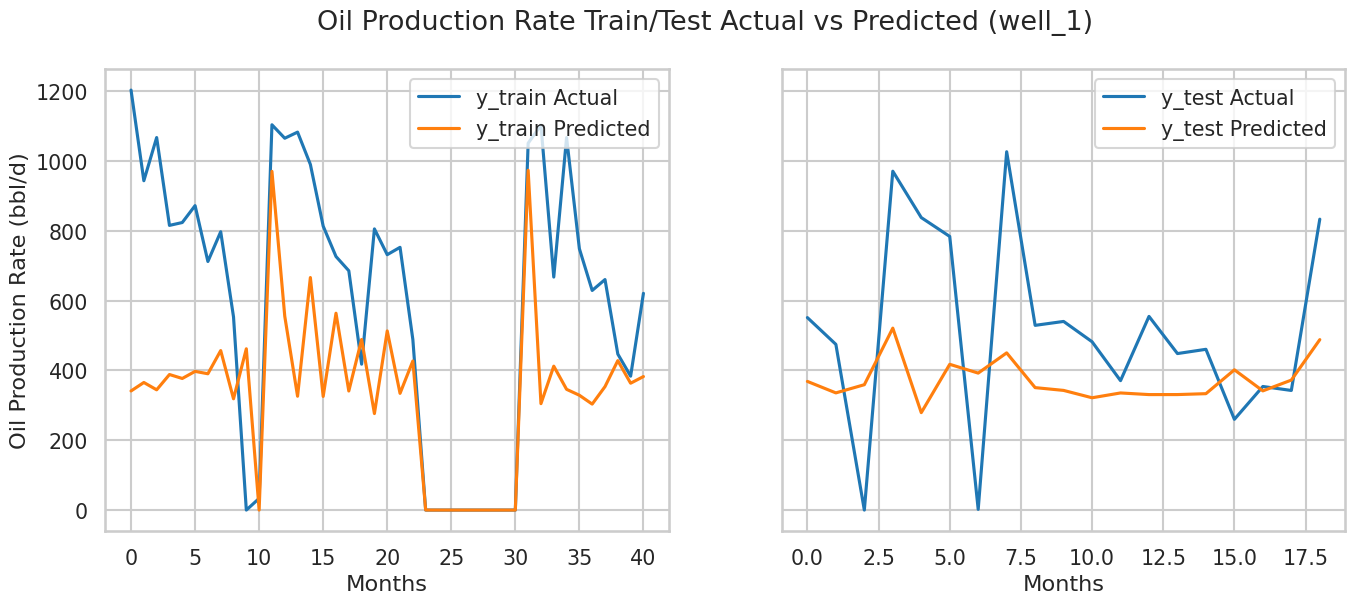

In [43]:
# Apply best Stacked LSTM tuned hyperparameters to Well 1
apply_best_hyperparameters(stacked_rmse_df, train_test_dict, 'well_1', model_type)

Best hyperparameters for well_2:
    look_back = 36
    n_nodes = 16
    learning_rate = 0.0019
    dropout = 0.1000
Loading best Optuna model from: optuna_lstm_models/stacked_well_2_trial_9.keras

Root Mean Squared Error Scores (well_2)

Train RMSE: 578.9
Test RMSE: 84.9


Actual vs Predicted Plots (well_2)



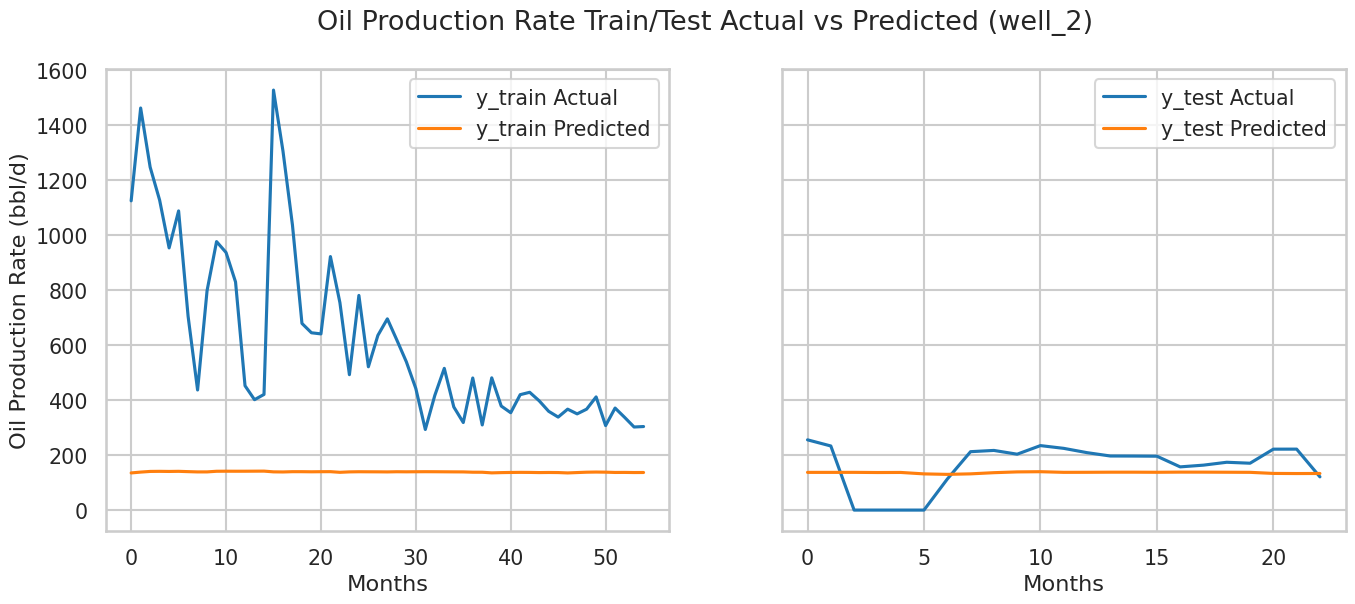

In [44]:
# Apply best Stacked LSTM tuned hyperparameters to Well 2
apply_best_hyperparameters(stacked_rmse_df, train_test_dict, 'well_2', model_type)

Best hyperparameters for well_3:
    look_back = 36
    n_nodes = 8
    learning_rate = 0.0016
    dropout = 0.3000
Loading best Optuna model from: optuna_lstm_models/stacked_well_3_trial_24.keras

Root Mean Squared Error Scores (well_3)

Train RMSE: 429.8
Test RMSE: 134.8


Actual vs Predicted Plots (well_3)



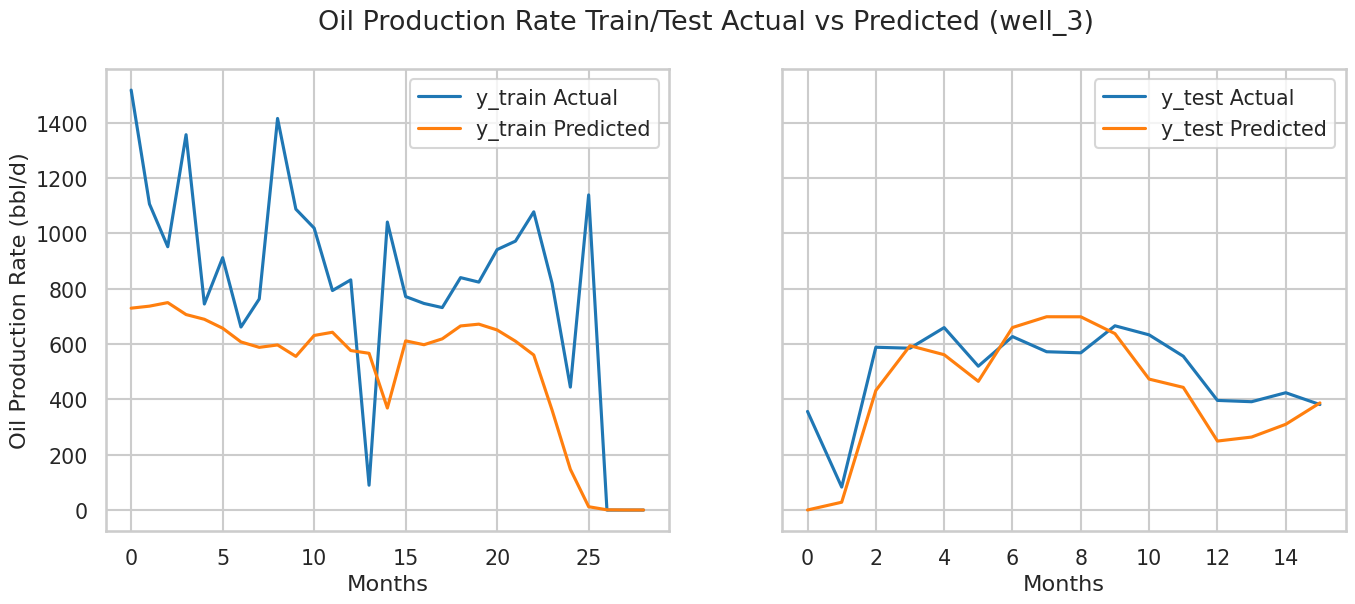

In [45]:
# Apply best Stacked LSTM tuned hyperparameters to Well 3
apply_best_hyperparameters(stacked_rmse_df, train_test_dict, 'well_3', model_type)

Best hyperparameters for well_4:
    look_back = 12
    n_nodes = 8
    learning_rate = 0.2074
    dropout = 0.5000
Loading best Optuna model from: optuna_lstm_models/stacked_well_4_trial_8.keras

Root Mean Squared Error Scores (well_4)

Train RMSE: 2,164.5
Test RMSE: 98.5


Actual vs Predicted Plots (well_4)



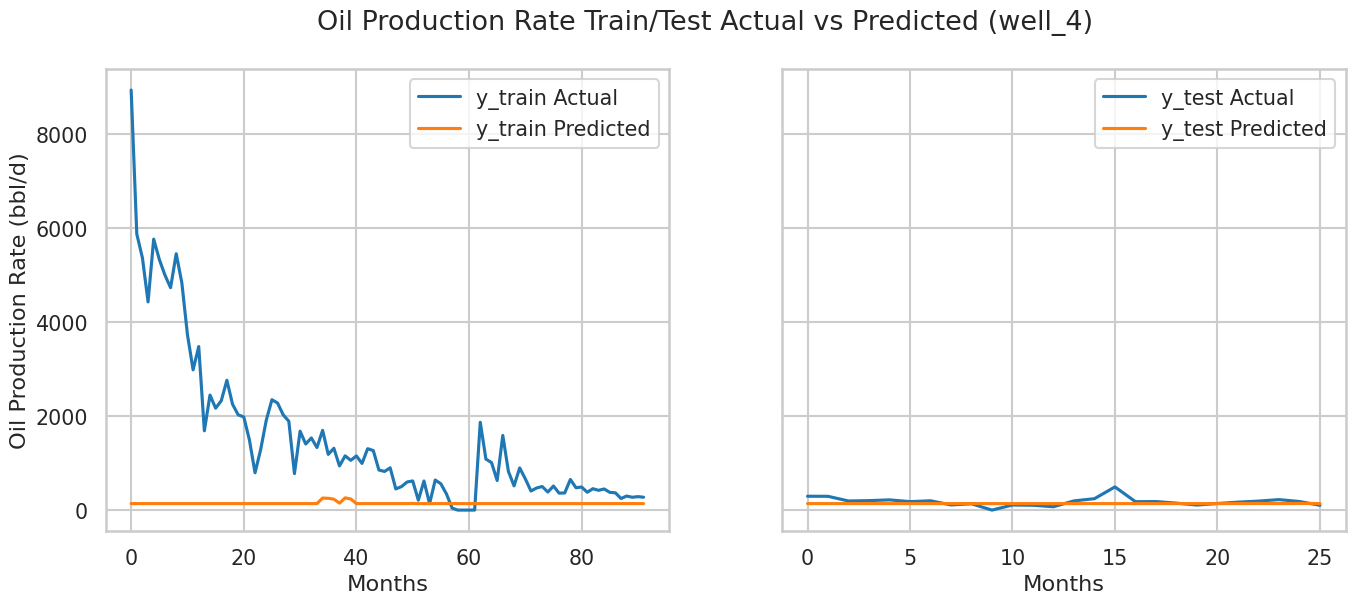

In [46]:
# Apply best Stacked LSTM tuned hyperparameters to Well 4
apply_best_hyperparameters(stacked_rmse_df, train_test_dict, 'well_4', model_type)

Best hyperparameters for well_5:
    look_back = 36
    n_nodes = 4
    learning_rate = 0.0131
    dropout = 0.0000
Loading best Optuna model from: optuna_lstm_models/stacked_well_5_trial_25.keras

Root Mean Squared Error Scores (well_5)

Train RMSE: 165.0
Test RMSE: 133.7


Actual vs Predicted Plots (well_5)



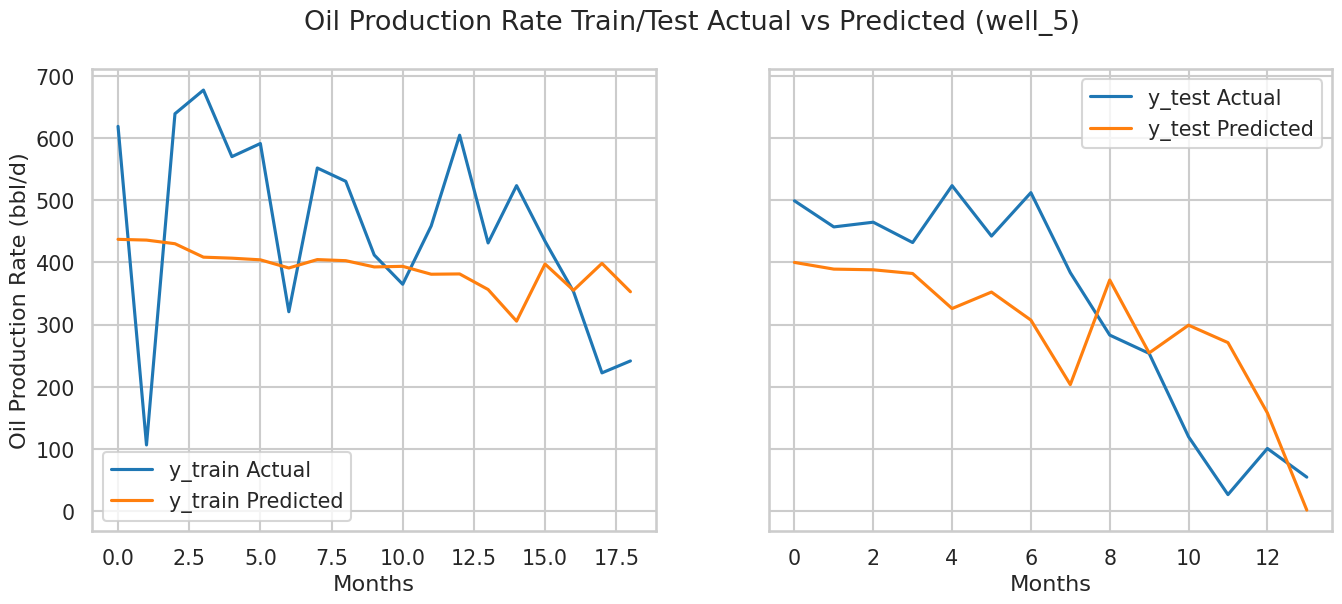

In [47]:
# Apply best Stacked LSTM tuned hyperparameters to Well 5
apply_best_hyperparameters(stacked_rmse_df, train_test_dict, 'well_5', model_type)

> Something about best HPs...

#### CNN-LSTM
- describe ...

In [48]:
# Create tuned CNN-LSTM models
model_type = 'cnn'
cnn_rmse_df = bayesian_tune_hyperparameters(model_type)

cnn Model Bayesian optimization trials for well_1:


  0%|          | 0/30 [00:00<?, ?it/s]

(look_back=24, n_nodes=4, learning_rate=0.0271, dropout=0.3000) -> RMSE=422.4264
(look_back=12, n_nodes=8, learning_rate=0.0023, dropout=0.4000) -> RMSE=523.2309
(look_back=12, n_nodes=16, learning_rate=0.2529, dropout=0.0000) -> RMSE=550.9573
(look_back=24, n_nodes=8, learning_rate=0.0040, dropout=0.2000) -> RMSE=294.8537
(look_back=12, n_nodes=4, learning_rate=0.1371, dropout=0.1000) -> RMSE=514.8333
(look_back=12, n_nodes=8, learning_rate=0.0017, dropout=0.0000) -> RMSE=529.1639
(look_back=12, n_nodes=8, learning_rate=0.0592, dropout=0.4000) -> RMSE=468.7613
(look_back=24, n_nodes=4, learning_rate=0.2495, dropout=0.4000) -> RMSE=423.6086
(look_back=12, n_nodes=8, learning_rate=0.0109, dropout=0.1000) -> RMSE=423.9408
(look_back=24, n_nodes=16, learning_rate=0.0351, dropout=0.1000) -> RMSE=557.5631
(look_back=36, n_nodes=8, learning_rate=0.0074, dropout=0.2000) -> RMSE=316.1149
(look_back=36, n_nodes=8, learning_rate=0.0068, dropout=0.2000) -> RMSE=385.2240
(look_back=36, n_nodes=8, 

cnn Model Bayesian optimization trials for well_2:


  0%|          | 0/30 [00:00<?, ?it/s]

(look_back=24, n_nodes=4, learning_rate=0.0060, dropout=0.2000) -> RMSE=166.8805
(look_back=12, n_nodes=8, learning_rate=0.0138, dropout=0.2000) -> RMSE=310.8923
(look_back=36, n_nodes=16, learning_rate=0.0693, dropout=0.4000) -> RMSE=155.9811
(look_back=24, n_nodes=16, learning_rate=0.0357, dropout=0.1000) -> RMSE=168.5200
(look_back=24, n_nodes=4, learning_rate=0.0010, dropout=0.1000) -> RMSE=156.0958
(look_back=36, n_nodes=4, learning_rate=0.1569, dropout=0.3000) -> RMSE=123.1720
(look_back=12, n_nodes=16, learning_rate=0.0681, dropout=0.0000) -> RMSE=163.7062
(look_back=12, n_nodes=4, learning_rate=0.3519, dropout=0.4000) -> RMSE=459.5859
(look_back=12, n_nodes=16, learning_rate=0.1415, dropout=0.4000) -> RMSE=96.4228
(look_back=12, n_nodes=4, learning_rate=0.0019, dropout=0.4000) -> RMSE=128.9749
(look_back=12, n_nodes=8, learning_rate=0.3651, dropout=0.5000) -> RMSE=169.8479
(look_back=36, n_nodes=16, learning_rate=0.1543, dropout=0.3000) -> RMSE=150.1888
(look_back=36, n_nodes=4

cnn Model Bayesian optimization trials for well_3:


  0%|          | 0/30 [00:00<?, ?it/s]

(look_back=24, n_nodes=8, learning_rate=0.0028, dropout=0.3000) -> RMSE=252.1473
(look_back=36, n_nodes=8, learning_rate=0.0013, dropout=0.4000) -> RMSE=256.3599
(look_back=24, n_nodes=4, learning_rate=0.0097, dropout=0.2000) -> RMSE=203.8517
(look_back=12, n_nodes=16, learning_rate=0.0237, dropout=0.3000) -> RMSE=363.0141
(look_back=12, n_nodes=4, learning_rate=0.0019, dropout=0.5000) -> RMSE=418.0704
(look_back=24, n_nodes=8, learning_rate=0.0068, dropout=0.4000) -> RMSE=374.9220
(look_back=36, n_nodes=16, learning_rate=0.4101, dropout=0.1000) -> RMSE=449.1757
(look_back=12, n_nodes=4, learning_rate=0.1257, dropout=0.4000) -> RMSE=381.7090
(look_back=24, n_nodes=16, learning_rate=0.3750, dropout=0.0000) -> RMSE=480.8118
(look_back=12, n_nodes=4, learning_rate=0.2998, dropout=0.2000) -> RMSE=483.2802
(look_back=24, n_nodes=4, learning_rate=0.0217, dropout=0.1000) -> RMSE=309.1151
(look_back=24, n_nodes=8, learning_rate=0.0060, dropout=0.2000) -> RMSE=320.7818
(look_back=24, n_nodes=8,

cnn Model Bayesian optimization trials for well_4:


  0%|          | 0/30 [00:00<?, ?it/s]

(look_back=12, n_nodes=4, learning_rate=0.0155, dropout=0.5000) -> RMSE=91.4287
(look_back=24, n_nodes=4, learning_rate=0.0026, dropout=0.0000) -> RMSE=143.7740
(look_back=36, n_nodes=4, learning_rate=0.0042, dropout=0.3000) -> RMSE=143.2654
(look_back=24, n_nodes=16, learning_rate=0.0578, dropout=0.5000) -> RMSE=166.0341
(look_back=36, n_nodes=4, learning_rate=0.4266, dropout=0.0000) -> RMSE=7582.6388
(look_back=24, n_nodes=16, learning_rate=0.0209, dropout=0.2000) -> RMSE=176.1958
(look_back=24, n_nodes=4, learning_rate=0.0039, dropout=0.5000) -> RMSE=129.7484
(look_back=12, n_nodes=4, learning_rate=0.3513, dropout=0.1000) -> RMSE=2924.0942
(look_back=12, n_nodes=8, learning_rate=0.0083, dropout=0.2000) -> RMSE=193.5939
(look_back=24, n_nodes=4, learning_rate=0.0154, dropout=0.1000) -> RMSE=161.6354
(look_back=12, n_nodes=8, learning_rate=0.0010, dropout=0.4000) -> RMSE=194.9525
(look_back=12, n_nodes=4, learning_rate=0.0415, dropout=0.5000) -> RMSE=97.1558
(look_back=12, n_nodes=4, 

cnn Model Bayesian optimization trials for well_5:


  0%|          | 0/30 [00:00<?, ?it/s]

(look_back=36, n_nodes=8, learning_rate=0.0823, dropout=0.0000) -> RMSE=269.6459
(look_back=36, n_nodes=8, learning_rate=0.0079, dropout=0.5000) -> RMSE=241.5334
(look_back=36, n_nodes=4, learning_rate=0.0090, dropout=0.5000) -> RMSE=262.3239
(look_back=12, n_nodes=4, learning_rate=0.0024, dropout=0.0000) -> RMSE=312.3921
(look_back=36, n_nodes=8, learning_rate=0.0088, dropout=0.3000) -> RMSE=251.3761
(look_back=36, n_nodes=8, learning_rate=0.0018, dropout=0.0000) -> RMSE=295.5341
(look_back=12, n_nodes=4, learning_rate=0.2054, dropout=0.3000) -> RMSE=296.6644
(look_back=12, n_nodes=4, learning_rate=0.3034, dropout=0.3000) -> RMSE=274.2688
(look_back=24, n_nodes=16, learning_rate=0.0029, dropout=0.4000) -> RMSE=269.5876
(look_back=36, n_nodes=4, learning_rate=0.0888, dropout=0.5000) -> RMSE=302.9075
(look_back=24, n_nodes=16, learning_rate=0.0227, dropout=0.2000) -> RMSE=300.2674
(look_back=36, n_nodes=8, learning_rate=0.0112, dropout=0.2000) -> RMSE=211.9129
(look_back=36, n_nodes=8, 

> something about HP tuning results...

In [49]:
# Display RMSE distributions
rmse_boxplots(cnn_rmse_df, model_type)

alt.Chart(...)

> something about boxplots...

Best hyperparameters for well_1:
    look_back = 24
    n_nodes = 8
    learning_rate = 0.0040
    dropout = 0.2000
Loading best Optuna model from: optuna_lstm_models/cnn_well_1_trial_3.keras

Root Mean Squared Error Scores (well_1)

Train RMSE: 579.4
Test RMSE: 294.9


Actual vs Predicted Plots (well_1)



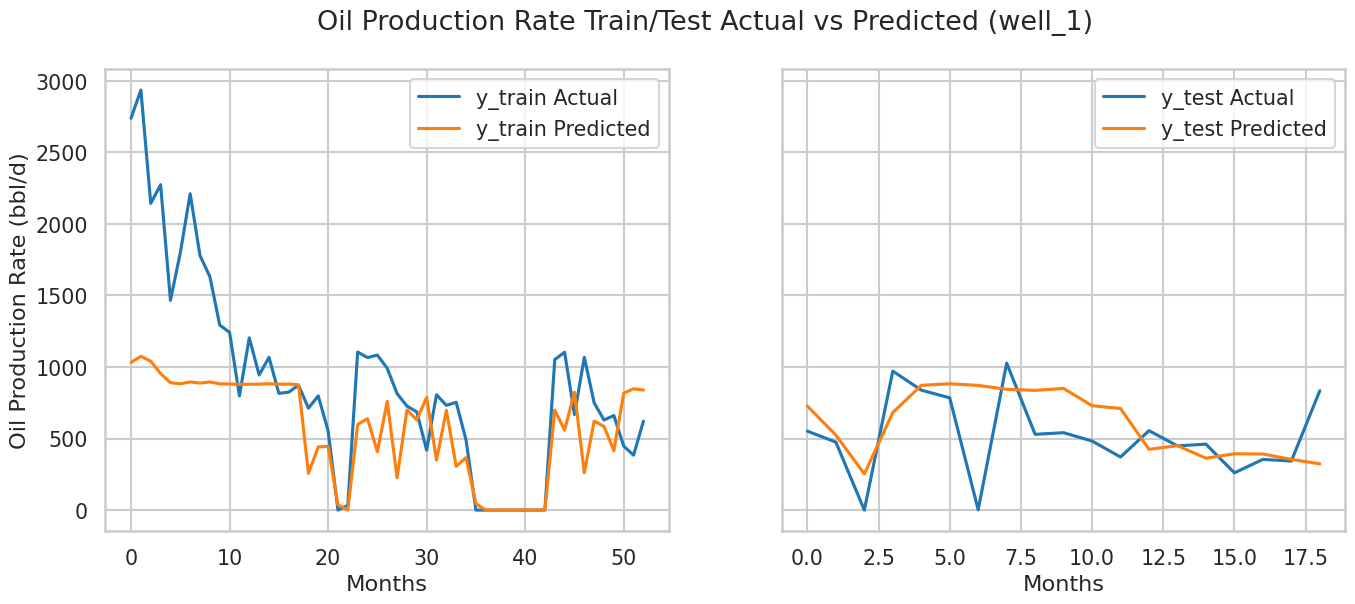

In [50]:
# Apply best CNN-LSTM tuned hyperparameters to Well 1
apply_best_hyperparameters(cnn_rmse_df, train_test_dict, 'well_1', model_type)

Best hyperparameters for well_2:
    look_back = 12
    n_nodes = 16
    learning_rate = 0.1415
    dropout = 0.4000
Loading best Optuna model from: optuna_lstm_models/cnn_well_2_trial_8.keras

Root Mean Squared Error Scores (well_2)

Train RMSE: 5,408.6
Test RMSE: 96.4


Actual vs Predicted Plots (well_2)



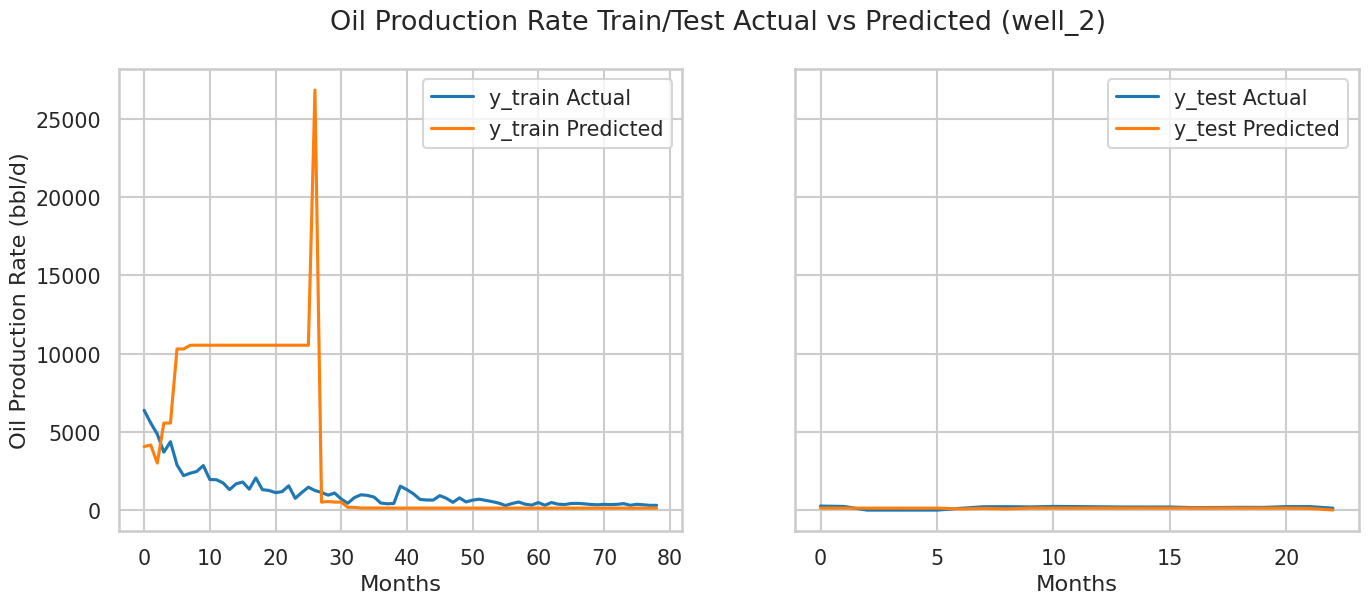

In [51]:
# Apply best CNN-LSTM tuned hyperparameters to Well 2
apply_best_hyperparameters(cnn_rmse_df, train_test_dict, 'well_2', model_type)

Best hyperparameters for well_3:
    look_back = 36
    n_nodes = 4
    learning_rate = 0.0049
    dropout = 0.2000
Loading best Optuna model from: optuna_lstm_models/cnn_well_3_trial_25.keras

Root Mean Squared Error Scores (well_3)

Train RMSE: 541.1
Test RMSE: 193.1


Actual vs Predicted Plots (well_3)



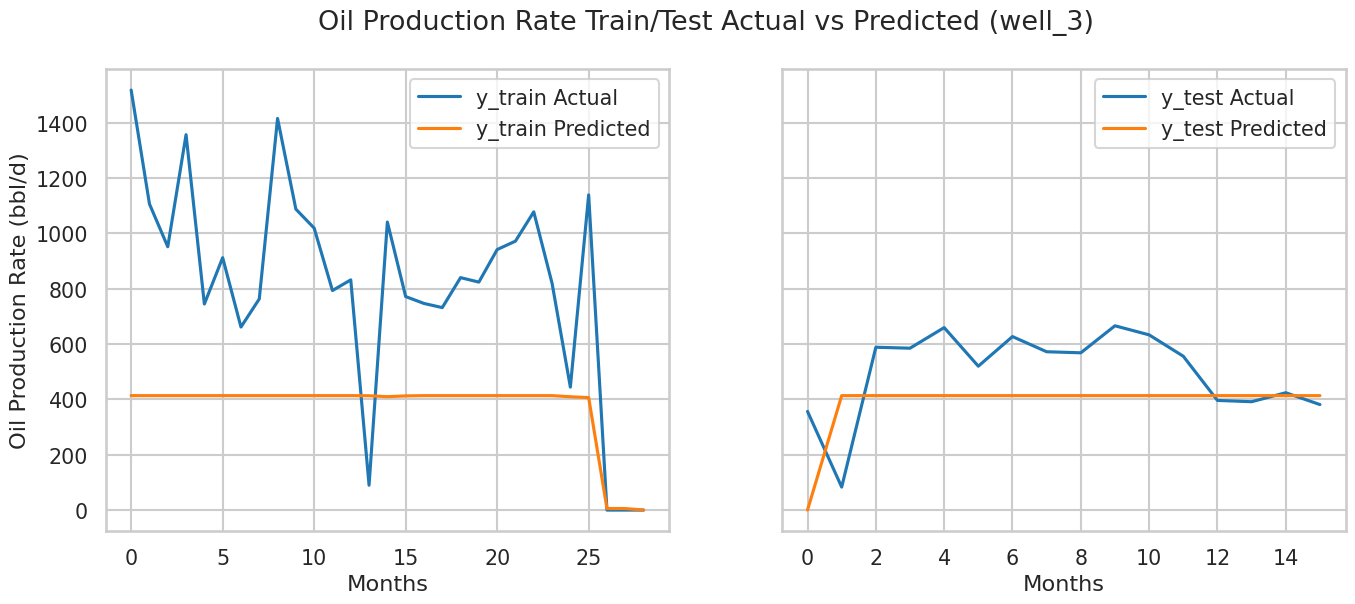

In [52]:
# Apply best CNN-LSTM tuned hyperparameters to Well 3
apply_best_hyperparameters(cnn_rmse_df, train_test_dict, 'well_3', model_type)

Best hyperparameters for well_4:
    look_back = 12
    n_nodes = 4
    learning_rate = 0.0155
    dropout = 0.5000
Loading best Optuna model from: optuna_lstm_models/cnn_well_4_trial_0.keras

Root Mean Squared Error Scores (well_4)

Train RMSE: 1,799.6
Test RMSE: 91.4


Actual vs Predicted Plots (well_4)



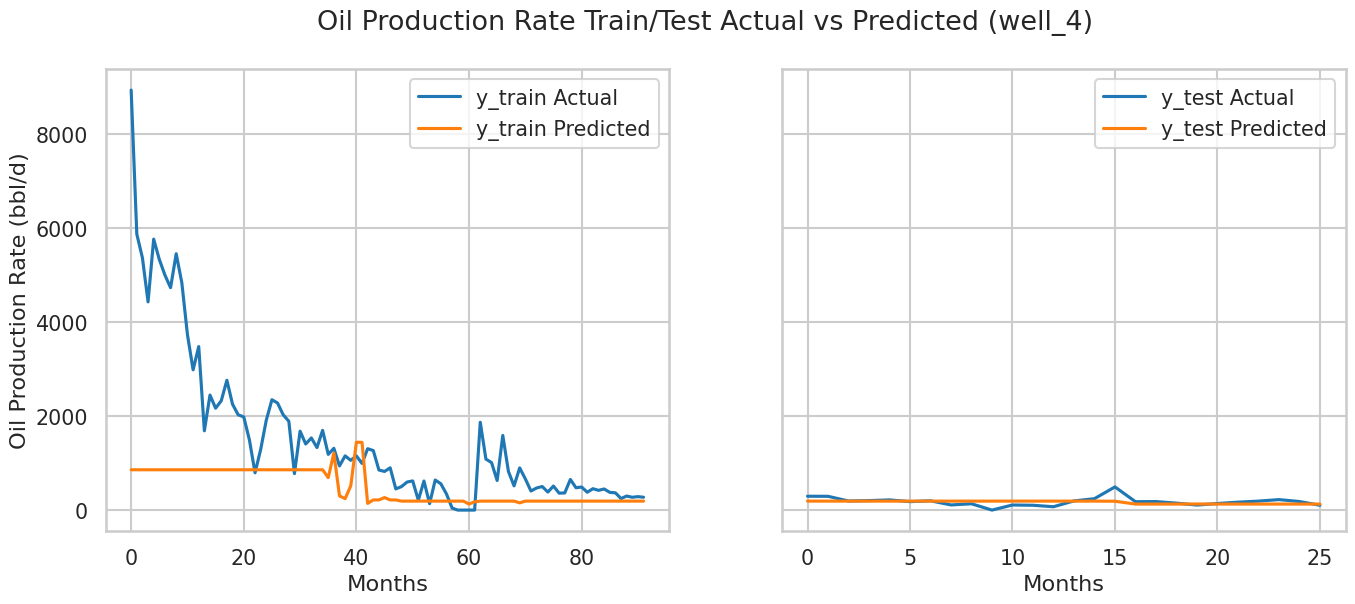

In [53]:
# Apply best CNN-LSTM tuned hyperparameters to Well 4
apply_best_hyperparameters(cnn_rmse_df, train_test_dict, 'well_4', model_type)

Best hyperparameters for well_5:
    look_back = 24
    n_nodes = 8
    learning_rate = 0.0041
    dropout = 0.3000
Loading best Optuna model from: optuna_lstm_models/cnn_well_5_trial_22.keras

Root Mean Squared Error Scores (well_5)

Train RMSE: 535.7
Test RMSE: 153.4


Actual vs Predicted Plots (well_5)



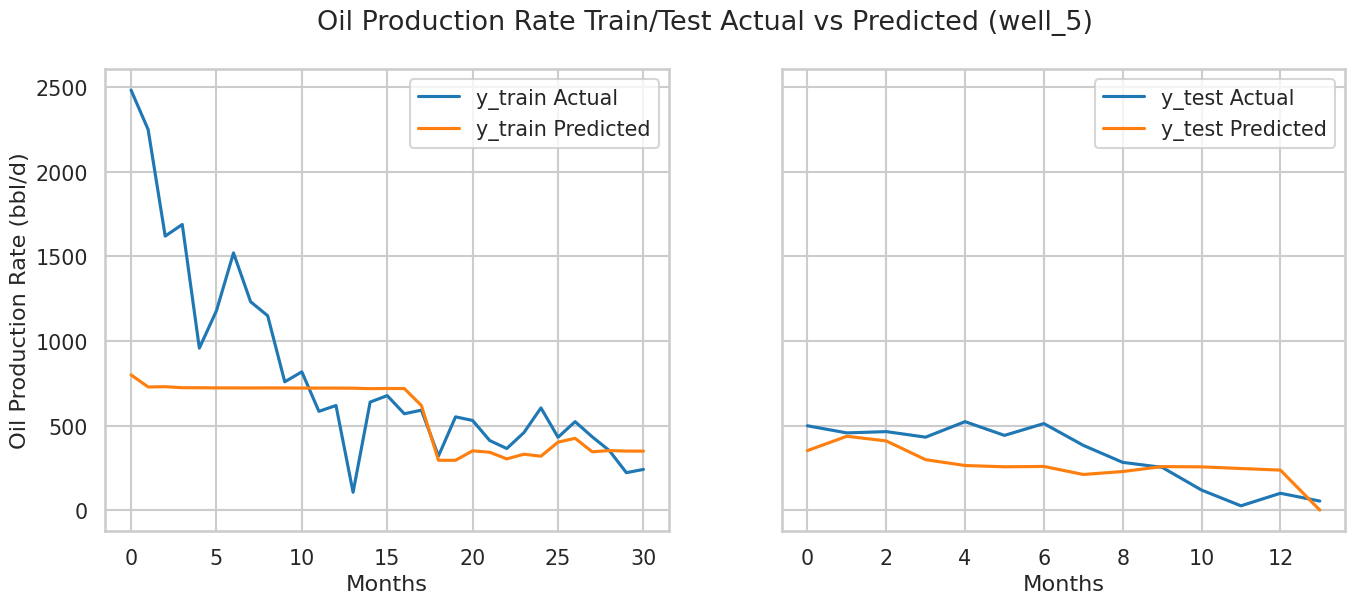

In [54]:
# Apply best CNN-LSTM tuned hyperparameters to Well 5
apply_best_hyperparameters(cnn_rmse_df, train_test_dict, 'well_5', model_type)

> Something about best HPs...

## RESULTS & ANALYSIS
- something about charting the progression of RMSE for the HP tuned models...

In [55]:
# Define a dictionary of the RMSE dataframes for each LSTM model
model_types_dict = {
    'Base LSTM':          base_rmse_df,
    'Bidirectional LSTM': bidirectional_rmse_df,
    'Stacked LSTM':       stacked_rmse_df,
    'CNN-LSTM':           cnn_rmse_df
}

# Find the best RMSE for each well and model type
best_rmse_df = pd.DataFrame([])
for model_type, df in model_types_dict.items():
    df = df.copy()
    df['model_type'] = model_type
    df = df[['well_name', 'test_rmse', 'model_type']].groupby(['well_name', 'model_type'], as_index=False).min()
    best_rmse_df = pd.concat([best_rmse_df, df])

best_rmse_df

well_name          model_type   test_rmse
0    well_1           Base LSTM  366.766779
1    well_2           Base LSTM   89.267653
2    well_3           Base LSTM  278.407777
3    well_4           Base LSTM  122.013996
4    well_5           Base LSTM  145.435517
0    well_1  Bidirectional LSTM  349.712365
1    well_2  Bidirectional LSTM  103.650960
2    well_3  Bidirectional LSTM  254.761394
3    well_4  Bidirectional LSTM  133.770216
4    well_5  Bidirectional LSTM  160.914124
0    well_1        Stacked LSTM  293.163233
1    well_2        Stacked LSTM   84.900729
2    well_3        Stacked LSTM  134.804292
3    well_4        Stacked LSTM   98.470915
4    well_5        Stacked LSTM  133.747564
0    well_1            CNN-LSTM  294.853688
1    well_2            CNN-LSTM   96.422817
2    well_3            CNN-LSTM  193.079687
3    well_4            CNN-LSTM   91.428710
4    well_5            CNN-LSTM  153.412027

In [56]:
# Plot best RMSE across models
alt.Chart(best_rmse_df).mark_line(
        size=5,
        strokeCap='round'
    ).encode(
        x=alt.X('model_type:N', title='Model Type'),
        y=alt.Y('test_rmse:Q', title='Test RMSE'),
        color=alt.Color('well_name:N', title='Well', scale=alt.Scale(scheme='viridis'))
    ).properties(
        width=600,
        height=400,
        title=alt.Title(
            'RMSE Progression by Well and Model Type',
            subtitle='Note: Best hyperparameter tuned RMSE used for each model type',
            fontSize=20,
            anchor='start'
        )
    )

alt.Chart(...)

> Summarize RMSE results. Highlight best models types for each well.

## CONCLUSION
Write a paragraph that summarizes:
1. Re-summarize project
2. Learning and takeaways
3. Why something didn’t work
4. Suggestions of ways to improve the model
    - Apply differencing
    - compare to other time series like ARMIA, Exponential Smoothing. or Prophet